In [3]:
# Set the experiment name to be something meaningful. 
# It will be part of the name of the model to be saved.
EXPERIMENT_NAME = "[HashNet]"
DEBUG = True        # Set to True if you want to see outputs used for debugging 
verbose = True      # Set to True if you want to see the loss function per epoch in real time

In [1]:
from IPython.display import SVG

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Input, Concatenate, Layer
from keras.layers.advanced_activations import ELU
from keras.applications import vgg19
from keras.utils import plot_model
from keras.optimizers import RMSprop, Adam
from keras import backend as K
from keras.utils.vis_utils import model_to_dot

import sys
import datetime
import keras
import pickle
import logging
import h5py
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy import ndimage
import scipy.io

from song_db import annotations
from preprocess import preprocess
from model import build_model

%matplotlib inline

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
logger = logging.getLogger()

# File Handler
fhandler = logging.FileHandler(filename='[{:}.log'.format(EXPERIMENT_NAME), mode='w')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)

# Output stream Handler
ch = logging.StreamHandler(sys.stdout)
ch.setFormatter(formatter)
logger.addHandler(ch)

if DEBUG: 
    logger.setLevel(logging.DEBUG)
    ch.setLevel(logging.DEBUG)
else:     
    logger.setLeveL(logging.INFO)
    ch.setLevel(logging.INFO)

## Config Keras

In this code, we will use tensorflow backend on Keras because it's relatively faster than Theano. We'll use the image data format in the form of `(n_channel, width, height)`. Please look at the Keras documentation for more details.

In [5]:
assert K.backend() == 'tensorflow'
logger.debug("Keras backend is tensorflow.")

K.set_image_data_format('channels_first')
assert K.image_data_format() == 'channels_first'
logger.debug("Keras image data format is channels_first")

2018-04-03 14:28:39,717 - root - DEBUG - Keras backend is tensorflow.
2018-04-03 14:28:39,722 - root - DEBUG - Keras image data format is channels_first


## Load dataset
We load the pair-annotation dataset. Here, we generate an array of of shapes `(n_pairs, 2, 76, 121)`.

In [ ]:
logger.debug("Load Paired-annotation data")
data = annotations.get_ref_query_pairs("taylorswift", beat_width=20)
logger.debug("\t data.type = {:}".format(type(data)))
logger.debug("\t data = {:}".format(data))

songPairs = []
totalPairs = 0
for ref, query in data:
    # Get pairs for each ref + query
    print(ref.shape, query.shape)
    curr_pairs = []
    for i in range(ref.shape[0]):
        refQ = preprocess(librosa.cqt(np.asfarray(ref[i], dtype='float32'), sr = 22050, fmin=130.81, n_bins=121, bins_per_octave=24, hop_length=96), 3).T
        queryQ = preprocess(librosa.cqt(np.asfarray(query[i], dtype='float32'), sr = 22050, fmin=130.81, n_bins=121, bins_per_octave=24, hop_length=96), 3).T
        Q_pair = np.append(np.array([refQ]), np.array([queryQ]), axis=0)[np.newaxis, :]
        curr_pairs.append(Q_pair)
    curr_pairs = np.vstack(tuple(curr_pairs))
    totalPairs += curr_pairs.shape[0]
    songPairs.append(curr_pairs)
    logger.debug("Song {:}: Finish current pairs with shape = {:}".format(len(songPairs), curr_pairs.shape))
    logger.debug("Number of samples for the current song: {:}".format(len(curr_pairs)))

logger.debug("There are {:} number of pairs".format(totalPairs))

2018-04-03 14:28:42,133 - root - DEBUG - Load Paired-annotation data
2018-04-03 14:28:42,137 - root - DEBUG - 	 data.type = <class 'generator'>
2018-04-03 14:28:42,139 - root - DEBUG - 	 data = <generator object get_ref_query_pairs at 0x00000172DEAA16D0>
(272, 20) (272, 20)


In [7]:
p_train = .6
cutOffIdx = 0
currentNumberOfPairs = 0
for song in songPairs:
    currentNumberOfPairs += song.shape[0]
    cutOffIdx += 1
    if currentNumberOfPairs >= totalPairs * p_train:
        break

data_train = tuple(songPairs[:cutOffIdx])
data_val = tuple(songPairs[cutOffIdx:])
logger.debug("Finish loading paired-annotation data")
logger.debug("=> There are {:} songs for training [{:.2f} percent]".format(len(data_train), (currentNumberOfPairs/totalPairs * 100.0)))
logger.debug("=> There are {:} songs for validation".format(len(data_val)))

2018-04-02 12:46:47,397 - root - DEBUG - Finish loading paired-annotation data
2018-04-02 12:46:47,398 - root - DEBUG - => There are 14 songs for training [63.52 percent]
2018-04-02 12:46:47,399 - root - DEBUG - => There are 6 songs for validation


## Preprocessing
Obtain a matrix $X_1$, $X_2$, $[w_{ij}]$, and $[s_{ij}]$ where $X_1$ and $X_2$ are pairs of images of shape 
`(n_samples, 1, width, height)`; $[w_{ij}]$ is the weight vector of shape `(n_samples, 1)` which describes the weight of each pair; and $[s_{ij}]$ is a binary vector of shape `(n_samples,1)` indicating whether inputs $i$ and $j$ are the same.

__Add similar pairs__

We add similar pairs based on the dataset we have.

__Add non-similar pairs__

We add non-similar pairs by randomly selecting two CQT frames from the dataset. Note that we say two CQT pairs are not similar when they come from different songs only.

__Data Post-processing__

Convert $X_1$, $X_2$, $[s_{ij}]$ in to numpy arrays.

__Calculate weights__

Calculate the weight vector $[w_{ij}]$. The term $w_{ij}$ is defined as 

$$
    w_{ij} = \begin{cases}
    \frac{|S|}{|S_{1}|} &\text{if $x^{(i)}$ is similar to $x^{(j)}$}\\
    \frac{|S|}{|S_{0}|} &\text{if $x^{(i)}$ is not similar to $x^{(j)}$}
    \end{cases}
$$

In [8]:
def generate_training_data(data, nNonSimilar=1000):
#     nPairs = data.shape[0] 
    X1 = []
    X2 = []
    S = []
    groundTruth = []
    
    # add similar pairs
    for songId in range(len(data)):
        nPairs = data[songId].shape[0]
        for idx in range(nPairs):
            X1.append(np.expand_dims(data[songId][idx][0][:][:], axis=0))
            X2.append(np.expand_dims(data[songId][idx][1][:][:], axis=0))
            groundTruth.append(((songId,idx),(songId,idx)))
            S.append(True)
        
    # add non-similar pairs
    for i in range(nNonSimilar):
        [songId1, songId2] = np.random.choice(len(data), 2, replace=False)
        nPairs1 = data[songId1].shape[0]
        nPairs2 = data[songId2].shape[0]

        [idx1] = np.random.choice(nPairs1, 1)
        [idx2] = np.random.choice(nPairs2, 1)
        X1.append(np.expand_dims(data[songId1][idx1][0][:][:], axis=0))
        X2.append(np.expand_dims(data[songId2][idx2][1][:][:], axis=0))
        S.append((songId1,idx1) == (songId2,idx2))
        groundTruth.append(((songId1,idx1),(songId2,idx2)))
        
    # post-processing
    X1 = np.array(X1)
    X2 = np.array(X2)
    S = np.array(S).reshape(-1,1)
    # calculate weights
    n_sim = len(S[S==True])
    w_sim   = len(X1) / n_sim             # w_ij for similar pairs
    w_insim = len(X1) / (len(X1) - n_sim)  # w_ij for dissimilar pairs
    W = S*w_sim + (~S)*w_insim          # w vector for pairs
    S = S.astype('float32')
    
    logger.debug("X1 shape: {:}".format(X1.shape))
    logger.debug("X2 shape: {:}".format(X2.shape))
    logger.debug("S shape: {:}".format(S.shape))
    logger.debug("W shape: {:}".format(W.shape))
    logger.debug("There are {:} out of {:} pairs that are similar [{:.2f} percent]".format(n_sim, 
                                                                                           len(X1),
                                                                                           100.0*n_sim/len(X1)))
    
    return X1, X2, S, W, groundTruth

In [9]:
X1, X2, S, W, groundTruth = generate_training_data(data_train, nNonSimilar=4000)
X1_val, X2_val, S_val, W_val, groundTruth_val = generate_training_data(data_val, nNonSimilar=2000)

2018-04-02 12:46:48,162 - root - DEBUG - X1 shape: (7237, 1, 76, 121)
2018-04-02 12:46:48,163 - root - DEBUG - X2 shape: (7237, 1, 76, 121)
2018-04-02 12:46:48,164 - root - DEBUG - S shape: (7237, 1)
2018-04-02 12:46:48,165 - root - DEBUG - W shape: (7237, 1)
2018-04-02 12:46:48,165 - root - DEBUG - There are 3237 out of 7237 pairs that are similar [44.73 percent]
2018-04-02 12:46:48,468 - root - DEBUG - X1 shape: (3859, 1, 76, 121)
2018-04-02 12:46:48,469 - root - DEBUG - X2 shape: (3859, 1, 76, 121)
2018-04-02 12:46:48,470 - root - DEBUG - S shape: (3859, 1)
2018-04-02 12:46:48,470 - root - DEBUG - W shape: (3859, 1)
2018-04-02 12:46:48,471 - root - DEBUG - There are 1859 out of 3859 pairs that are similar [48.17 percent]


In [10]:
nPairs = X1.shape[0]

## Model

__Define inputs__

Create a HashNet model with four inputs: two images tensors, similarity vector, and weight vector.

In [70]:
width = 20
height = 121
n_channel = 1

In [71]:
image_a    = Input(shape=(n_channel, width, height), name='image_1')
image_b    = Input(shape=(n_channel, width, height), name='image_2')
similarity = Input(shape=(1,), name="similarity")
weight     = Input(shape=(1,), name="weight")

__Pre-trained model__

Use a pre-trained model here to obtain intermediate values from the pre-trained model. We call this pre-trained model by `base_model`. The `base_model` is generally used to convert a CQT image to some representation.

In [72]:
model_path = 'model.mat'
model = scipy.io.loadmat(model_path)
logger.debug("Load model from {:}".format(model_path))
evecs = np.array(model['eigvecs']).T

2018-04-03 12:32:38,058 - root - DEBUG - Load model from model.mat


In [73]:
m = 20
pca_matrix = np.array([vec.reshape((m, -1)) for vec in evecs])
delta = 4
base_model = build_model(pca_matrix, (width, height), delta=delta, compute_delta=False)

In [74]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 64, 1, 1)          154880    
Total params: 154,880
Trainable params: 154,880
Non-trainable params: 0
_________________________________________________________________


2018-04-03 12:32:40,479 - root - DEBUG - Save base_model architecture to base_model.png


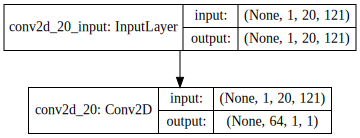

In [75]:
plot_model(base_model, show_shapes=True, to_file='base_model.png')
logger.debug("Save base_model architecture to base_model.png")
SVG(model_to_dot(base_model, show_shapes=True).create(prog='dot', format='svg'))

__Obtain intermediate values__

Intermediate values are values directly after the base model.

In [22]:
# Obtain intermediate tensor
intermediate_a = base_model(image_a)
intermediate_b = base_model(image_b)

# Flatten the layer
flatten_a = Flatten()(intermediate_a)
flatten_b = Flatten()(intermediate_b)

__Append a layer for binary encoding__

This layer has a `tanh` activation defined in the same way as HashNet paper. Note that initial beta value, number of bits, and `alpha` in the block below are hyperparameters.

In [23]:
beta         = 1            # Initial beta value
numberOfBits = 256
alpha        = 0.01         # Set to be something small because it prevents the loss function from blowing up.
logger.debug("[HashNet Model] beta = {:}, numberOfBits = {:}, alpha = {:}".format(beta, numberOfBits, alpha))

2018-04-03 12:28:40,421 - root - DEBUG - [HashNet Model] beta = 1, numberOfBits = 256, alpha = 0.01


In [24]:
def custom_activation(x):
    """
    Our own defined activation function
    """
    global beta
    return K.tanh(beta * x)

In [25]:
class CustomizedLossLayer(Layer):
    """
    Our own defined layer for keeping track of loss function
    """
    
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomizedLossLayer, self).__init__(**kwargs)
    
    def my_loss(self, encoded_a, encoded_b, similarity, weight):
        global alpha
        x = encoded_a
        y = encoded_b
        dot_product = K.sum(x * y, axis=-1, keepdims=True)
        logger.debug(dot_product)
        return K.sum(weight * (K.log(1 + K.exp(alpha * dot_product)) - alpha * similarity * dot_product))
    
    def call(self, inputs):
        encoded_a = inputs[0]
        encoded_b = inputs[1]
        similarity = inputs[2]
        weight = inputs[3]
        loss = self.my_loss(encoded_a, encoded_b, similarity, weight)
        self.add_loss(loss, inputs=inputs)
        return K.ones_like(similarity)


In [26]:
hash_layer = Activation('tanh')
encoded_a = hash_layer(flatten_a)
encoded_b = hash_layer(flatten_b)

__Create a model for training__

We construct a model using 2 representations derived by the same base model and similarity and weight. The architecture of the model is given below.

In [27]:
# Define a loss layer with 4 inputs
loss = CustomizedLossLayer()([encoded_a, encoded_b, similarity, weight])

2018-04-03 12:28:43,310 - root - DEBUG - Tensor("customized_loss_layer_1/Sum:0", shape=(?, 1), dtype=float32)


In [28]:
# Define a model that has 4 inputs and outputs loss
model = Model(inputs=[image_a, image_b, similarity, weight], outputs=[loss])

In [29]:
# Compile the model with our own defined loss function.
# Note that loss function is already defined in a layer, so
# `zero_loss` here doesn't actually do anything.

def zero_loss(y_true, y_pred):
    return K.zeros_like(y_pred)

logger.debug("Use Adam optimizer with lr = 1e-5")
adam = Adam(lr=1e-5)
model.compile(optimizer=adam, loss=zero_loss)

2018-04-03 12:28:44,114 - root - DEBUG - Use Adam optimizer with lr = 1e-5


__Visualize model architecture__

2018-04-03 12:28:45,723 - root - DEBUG - Save model architecture to model.png


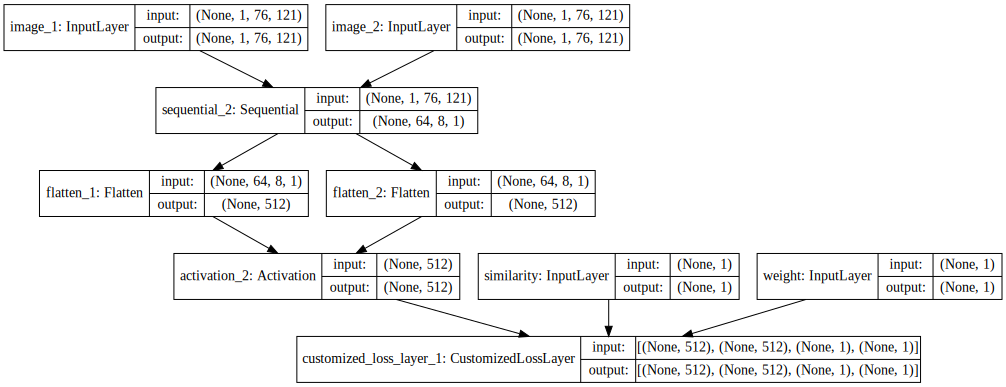

In [30]:
plot_model(model, show_shapes=True, to_file='model.png')
logger.debug("Save model architecture to model.png")
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Visualize performance before training

For the purpose of understanding the performance of this algorithm, we find the baseline result by computing the hamming distance between two representations before training and then plotting the corresponding histogram. Based on the above diagram, we use the representation at layers named `flatten_1` and `flatten_2`, before the fully connected layer defined by HashNet paper.

In [156]:
representation_model = Model(image_a, flatten_a)

In [157]:
def visualize(X1, X2, groundTruth, model):
    plt.figure()
    hist_sim = []
    hist_non_sim = []

    pred_X1 = (model.predict(X1) > 0)
    pred_X2 = (model.predict(X2) > 0)
    for idx in range(len(X1)):
        score = np.count_nonzero(pred_X1[idx] != pred_X2[idx])
        similarity = (groundTruth[idx][0] == groundTruth[idx][1])

        if similarity:
            hist_sim.append(score)
        else:
            hist_non_sim.append(score)

    bins = np.linspace(0, max(max(hist_sim), max(hist_non_sim)), 100)
    plt.ylim((0, 135))
    plt.ylabel("Count")
    plt.xlabel("$|x-y|$, e.g. Hamming distance")
    plt.hist(hist_sim, bins, alpha=0.5, label='Similar pairs', color='blue')
    plt.hist(hist_non_sim, bins, alpha=0.5, label='Non-similar pairs', color='orange')
    plt.legend()
    plt.show()

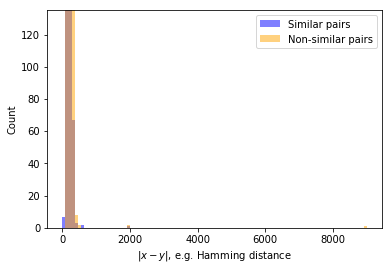

In [158]:
visualize(X1, X2, groundTruth, representation_model)

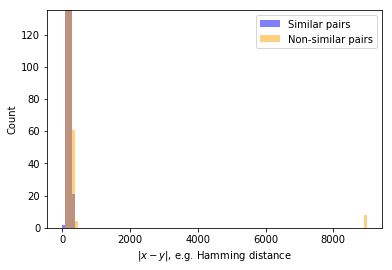

In [159]:
visualize(X1_val, X2_val, groundTruth_val, representation_model)

## Train a model

In [160]:
# Check the input shape
logger.debug("Ready to train the model")
logger.debug("X1 shape: {:}".format(X1.shape))
logger.debug("X2 shape: {:}".format(X2.shape))
logger.debug("S shape: {:}".format(S.shape))
logger.debug("W shape: {:}".format(W.shape))

2018-03-09 14:07:33,836 - root - DEBUG - Ready to train the model
2018-03-09 14:07:33,837 - root - DEBUG - X1 shape: (7237, 1, 76, 121)
2018-03-09 14:07:33,838 - root - DEBUG - X2 shape: (7237, 1, 76, 121)
2018-03-09 14:07:33,838 - root - DEBUG - S shape: (7237, 1)
2018-03-09 14:07:33,839 - root - DEBUG - W shape: (7237, 1)


In [161]:
number_of_iterations = 3
logger.debug("[Training] number_of_iterations = {:}".format(number_of_iterations))
beta = 1
beta_factor = 1.5
logger.debug("[Training] beta_factor = {:}".format(beta_factor))
number_of_epochs = 20
logger.debug("[Training] number_of_epochs = {:}".format(number_of_epochs))

2018-03-09 14:07:33,959 - root - DEBUG - [Training] number_of_iterations = 3
2018-03-09 14:07:33,960 - root - DEBUG - [Training] beta_factor = 1.5
2018-03-09 14:07:33,960 - root - DEBUG - [Training] number_of_epochs = 20


In [ ]:
train_losses = []
test_losses = []
m = 0

2018-03-09 18:56:37,860 - root - DEBUG - Iteration 10 (current beta = 57.6650390625)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 24.2211
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 24.1946
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 24.1726
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 24.1409
Epoch 5/20
7237/7237 [==============================] - 11s 1ms/step - loss: 24.1547
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 24.1165
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 24.1061
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 24.0549
Epoch 9/20
7237/7237 [==============================] - 11s 1ms/step - loss: 24.0170
Epoch 10/20
7237/7237 [==============================] - 11s 1ms/step - loss: 24.0691
Epoch 11/20
7237/7237 [==============================] - 11s 1ms

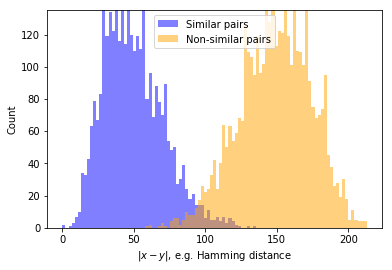

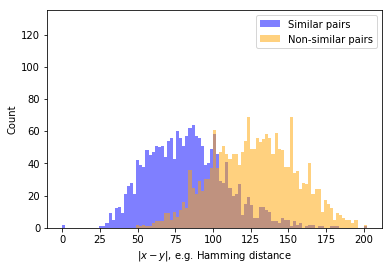

3859/3859 [==============================] - 2s 433us/step
2018-03-09 19:00:18,264 - root - DEBUG - [Iteration = 11] Training Loss = 23.623575260317324, Testing Loss = 35.247337279526114
2018-03-09 19:00:18,265 - root - DEBUG - Iteration 11 (current beta = 86.49755859375)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 23.8232
Epoch 2/20
7237/7237 [==============================] - 11s 1ms/step - loss: 23.8158
Epoch 3/20
7237/7237 [==============================] - 11s 1ms/step - loss: 23.7900
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 23.7915
Epoch 5/20
7237/7237 [==============================] - 11s 1ms/step - loss: 23.7453
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 23.7862
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 23.7143
Epoch 8/20
7237/7237 [==============================] - 11s 1ms/step - loss: 23.7048
Epoch 9/20
7237/7237 [=========================

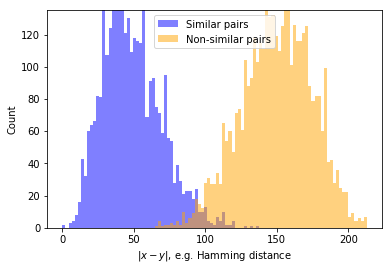

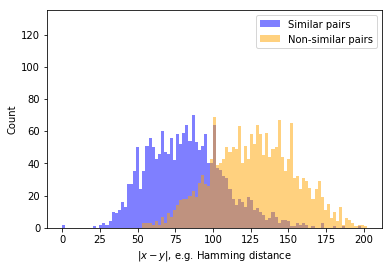

3859/3859 [==============================] - 2s 438us/step
2018-03-09 19:03:58,671 - root - DEBUG - [Iteration = 12] Training Loss = 23.29382796707248, Testing Loss = 35.36499134151699
2018-03-09 19:03:58,672 - root - DEBUG - Iteration 12 (current beta = 129.746337890625)
Epoch 1/20
7237/7237 [==============================] - 11s 1ms/step - loss: 23.4890
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 23.4776
Epoch 3/20
7237/7237 [==============================] - 11s 1ms/step - loss: 23.4731
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 23.4907
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 23.4111
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 23.4155
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 23.4306
Epoch 8/20
7237/7237 [==============================] - 11s 1ms/step - loss: 23.3887
Epoch 9/20
7237/7237 [=========================

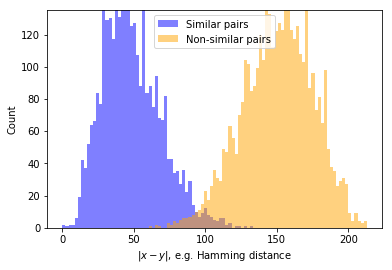

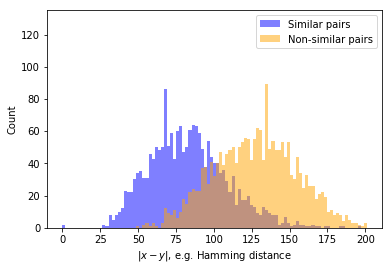

3859/3859 [==============================] - 2s 412us/step
2018-03-09 19:07:39,309 - root - DEBUG - [Iteration = 13] Training Loss = 22.966544409194867, Testing Loss = 35.33192241794243
2018-03-09 19:07:39,310 - root - DEBUG - Iteration 13 (current beta = 194.6195068359375)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 23.2011
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 23.1649
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 23.1619
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 23.1577
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 23.1605
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 23.1584
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 23.1177
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 23.1265
Epoch 9/20
7237/7237 [=======================

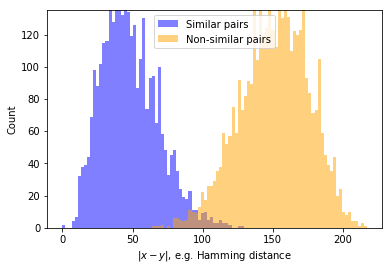

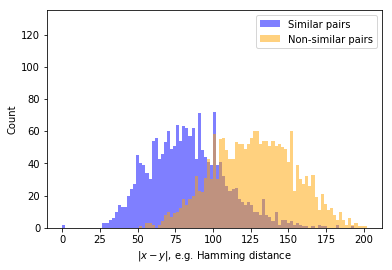

3859/3859 [==============================] - 2s 436us/step
2018-03-09 19:11:16,408 - root - DEBUG - [Iteration = 14] Training Loss = 22.743978989261016, Testing Loss = 35.31798616633201
2018-03-09 19:11:16,409 - root - DEBUG - Iteration 14 (current beta = 291.92926025390625)
Epoch 1/20
7237/7237 [==============================] - 11s 1ms/step - loss: 22.9302
Epoch 2/20
7237/7237 [==============================] - 11s 1ms/step - loss: 22.9375
Epoch 3/20
7237/7237 [==============================] - 11s 1ms/step - loss: 22.9375
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 22.9042
Epoch 5/20
7237/7237 [==============================] - 11s 1ms/step - loss: 22.9252
Epoch 6/20
7237/7237 [==============================] - 11s 1ms/step - loss: 22.9133
Epoch 7/20
7237/7237 [==============================] - 11s 1ms/step - loss: 22.9095
Epoch 8/20
7237/7237 [==============================] - 11s 1ms/step - loss: 22.8633
Epoch 9/20
7237/7237 [======================

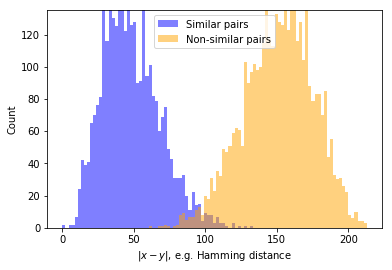

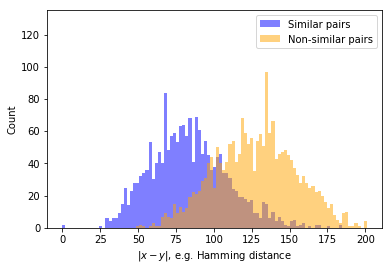

3859/3859 [==============================] - 2s 436us/step
2018-03-09 19:14:57,826 - root - DEBUG - [Iteration = 15] Training Loss = 22.73727796610439, Testing Loss = 35.31191439009541
2018-03-09 19:14:57,826 - root - DEBUG - Iteration 15 (current beta = 437.8938903808594)
Epoch 1/20
7237/7237 [==============================] - 11s 1ms/step - loss: 22.6961
Epoch 2/20
7237/7237 [==============================] - 11s 1ms/step - loss: 22.6716
Epoch 3/20
7237/7237 [==============================] - 11s 1ms/step - loss: 22.6983
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 22.7023
Epoch 5/20
7237/7237 [==============================] - 11s 1ms/step - loss: 22.6689
Epoch 6/20
7237/7237 [==============================] - 11s 1ms/step - loss: 22.6687
Epoch 7/20
7237/7237 [==============================] - 11s 1ms/step - loss: 22.6183
Epoch 8/20
7237/7237 [==============================] - 11s 1ms/step - loss: 22.6582
Epoch 9/20
7237/7237 [========================

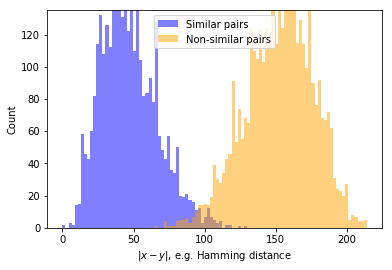

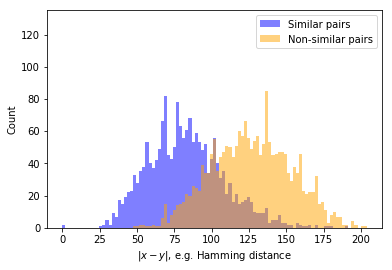

3859/3859 [==============================] - 2s 439us/step
2018-03-09 19:18:38,612 - root - DEBUG - [Iteration = 16] Training Loss = 22.359506143725707, Testing Loss = 35.477460811285816
2018-03-09 19:18:38,613 - root - DEBUG - Iteration 16 (current beta = 656.8408355712891)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 22.5068
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 22.4832
Epoch 3/20
7237/7237 [==============================] - 11s 1ms/step - loss: 22.4829
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 22.4641
Epoch 5/20
7237/7237 [==============================] - 11s 1ms/step - loss: 22.4474
Epoch 6/20
7237/7237 [==============================] - 11s 1ms/step - loss: 22.4675
Epoch 7/20
7237/7237 [==============================] - 11s 1ms/step - loss: 22.4305
Epoch 8/20
7237/7237 [==============================] - 11s 1ms/step - loss: 22.4145
Epoch 9/20
7237/7237 [======================

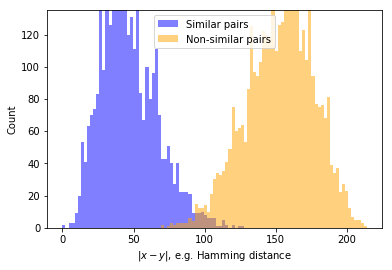

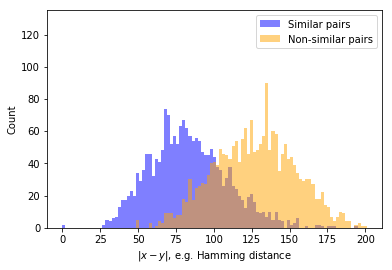

3859/3859 [==============================] - 2s 440us/step
2018-03-09 19:22:20,009 - root - DEBUG - [Iteration = 17] Training Loss = 22.173093902516204, Testing Loss = 35.40527726010542
2018-03-09 19:22:20,010 - root - DEBUG - Iteration 17 (current beta = 985.2612533569336)
Epoch 1/20
7237/7237 [==============================] - 11s 1ms/step - loss: 22.3055
Epoch 2/20
7237/7237 [==============================] - 11s 1ms/step - loss: 22.2724
Epoch 3/20
7237/7237 [==============================] - 11s 1ms/step - loss: 22.2832
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 22.2819
Epoch 5/20
7237/7237 [==============================] - 11s 1ms/step - loss: 22.2685
Epoch 6/20
7237/7237 [==============================] - 11s 1ms/step - loss: 22.2474
Epoch 7/20
7237/7237 [==============================] - 11s 1ms/step - loss: 22.2244
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 22.2201
Epoch 9/20
7237/7237 [=======================

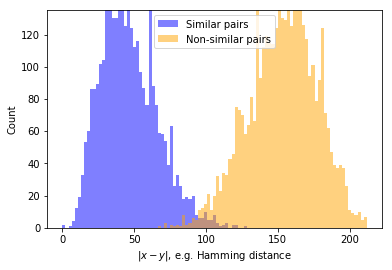

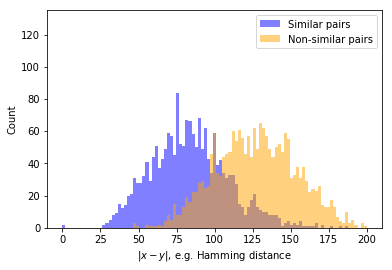

3859/3859 [==============================] - 2s 413us/step
2018-03-09 19:26:01,113 - root - DEBUG - [Iteration = 18] Training Loss = 21.999696978452672, Testing Loss = 35.417707798115856
2018-03-09 19:26:01,114 - root - DEBUG - Iteration 18 (current beta = 1477.8918800354004)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 22.0943
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 22.1397
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 22.1081
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 22.0905
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 22.0831
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 22.0959
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 22.0420
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 22.0999
Epoch 9/20
7237/7237 [=====================

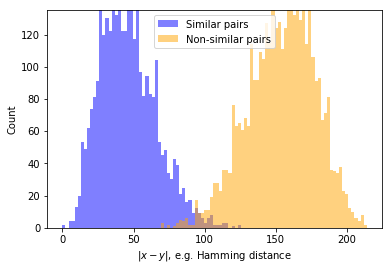

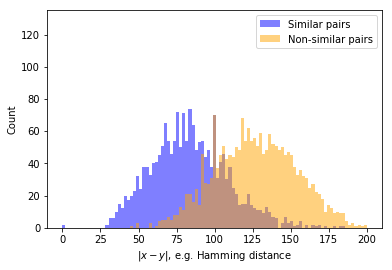

3859/3859 [==============================] - 2s 439us/step
2018-03-09 19:29:38,174 - root - DEBUG - [Iteration = 19] Training Loss = 21.78813712254601, Testing Loss = 35.50821831993069
2018-03-09 19:29:38,176 - root - DEBUG - Iteration 19 (current beta = 2216.8378200531006)
Epoch 1/20
7237/7237 [==============================] - 11s 1ms/step - loss: 21.9545
Epoch 2/20
7237/7237 [==============================] - 11s 1ms/step - loss: 21.9401
Epoch 3/20
7237/7237 [==============================] - 11s 1ms/step - loss: 21.9469
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 21.9214
Epoch 5/20
7237/7237 [==============================] - 11s 1ms/step - loss: 21.9097
Epoch 6/20
7237/7237 [==============================] - 11s 1ms/step - loss: 21.9211
Epoch 7/20
7237/7237 [==============================] - 11s 1ms/step - loss: 21.8986
Epoch 8/20
7237/7237 [==============================] - 11s 1ms/step - loss: 21.9079
Epoch 9/20
7237/7237 [=======================

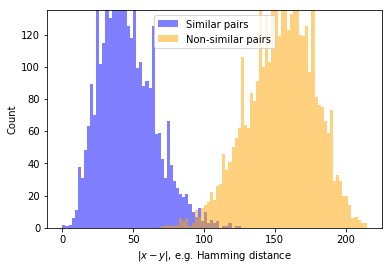

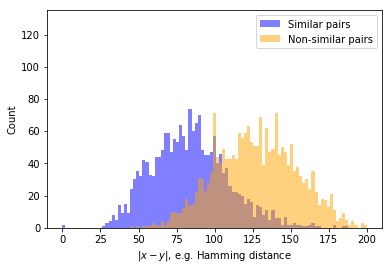

3859/3859 [==============================] - 2s 441us/step
2018-03-09 19:33:19,346 - root - DEBUG - [Iteration = 20] Training Loss = 21.67439627716583, Testing Loss = 35.31923330988591
2018-03-09 19:33:19,347 - root - DEBUG - Iteration 20 (current beta = 3325.256730079651)
Epoch 1/20
7237/7237 [==============================] - 11s 1ms/step - loss: 21.8042
Epoch 2/20
7237/7237 [==============================] - 11s 1ms/step - loss: 21.8065
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 21.7545
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 21.7786
Epoch 5/20
7237/7237 [==============================] - 11s 1ms/step - loss: 21.7512
Epoch 6/20
7237/7237 [==============================] - 11s 1ms/step - loss: 21.7928
Epoch 7/20
7237/7237 [==============================] - 11s 1ms/step - loss: 21.7459
Epoch 8/20
7237/7237 [==============================] - 11s 1ms/step - loss: 21.7149
Epoch 9/20
7237/7237 [========================

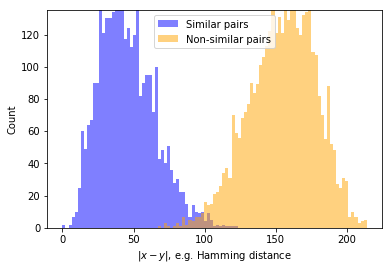

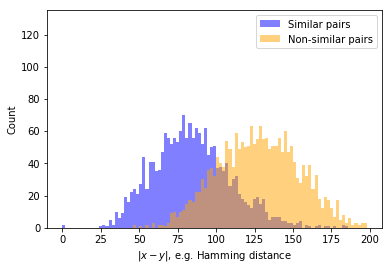

3859/3859 [==============================] - 2s 412us/step
2018-03-09 19:36:59,834 - root - DEBUG - [Iteration = 21] Training Loss = 21.523783328372733, Testing Loss = 35.466282061883035
2018-03-09 19:36:59,835 - root - DEBUG - Iteration 21 (current beta = 4987.885095119476)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 21.6682
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 21.6202
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 21.5970
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 21.6074
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 21.5962
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 21.6026
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 21.5678
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 21.5841
Epoch 9/20
7237/7237 [======================

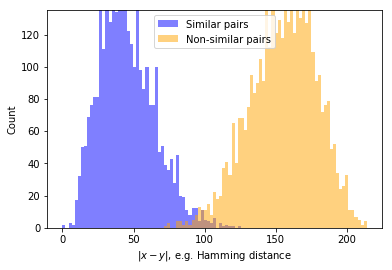

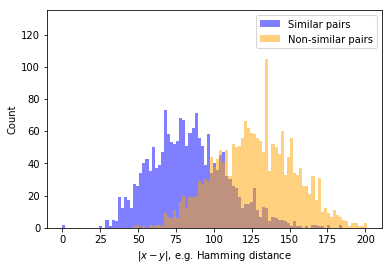

3859/3859 [==============================] - 2s 438us/step
2018-03-09 19:40:37,317 - root - DEBUG - [Iteration = 22] Training Loss = 21.397564482125556, Testing Loss = 35.451851795114486
2018-03-09 19:40:37,318 - root - DEBUG - Iteration 22 (current beta = 7481.8276426792145)
Epoch 1/20
7237/7237 [==============================] - 11s 1ms/step - loss: 21.5171
Epoch 2/20
7237/7237 [==============================] - 11s 1ms/step - loss: 21.4731
Epoch 3/20
7237/7237 [==============================] - 11s 1ms/step - loss: 21.4798
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 21.4933
Epoch 5/20
7237/7237 [==============================] - 11s 1ms/step - loss: 21.4784
Epoch 6/20
7237/7237 [==============================] - 11s 1ms/step - loss: 21.4940
Epoch 7/20
7237/7237 [==============================] - 11s 1ms/step - loss: 21.4783
Epoch 8/20
7237/7237 [==============================] - 11s 1ms/step - loss: 21.4721
Epoch 9/20
7237/7237 [=====================

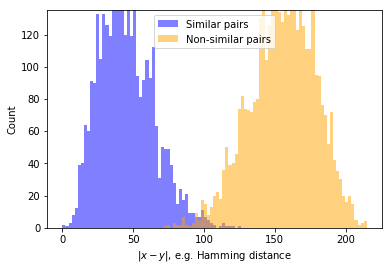

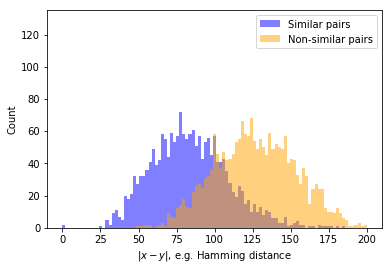

3859/3859 [==============================] - 2s 412us/step
2018-03-09 19:44:18,214 - root - DEBUG - [Iteration = 23] Training Loss = 21.28570097791106, Testing Loss = 35.48207199885518
2018-03-09 19:44:18,215 - root - DEBUG - Iteration 23 (current beta = 11222.741464018822)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 21.3577
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 21.3572
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 21.3549
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 21.3646
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 21.3485
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 21.3323
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 21.3495
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 21.3336
Epoch 9/20
7237/7237 [=======================

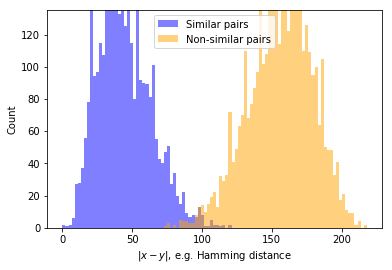

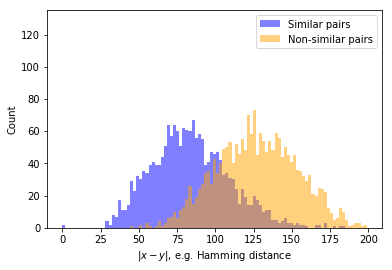

3859/3859 [==============================] - 2s 406us/step
2018-03-09 19:47:55,053 - root - DEBUG - [Iteration = 24] Training Loss = 21.11465499413282, Testing Loss = 35.483807779526146
2018-03-09 19:47:55,054 - root - DEBUG - Iteration 24 (current beta = 16834.112196028233)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 21.2407
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 21.2225
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 21.2341
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 21.2337
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 21.2372
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 21.2439
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 21.2291
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 21.2150
Epoch 9/20
7237/7237 [======================

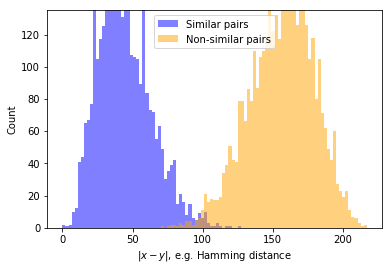

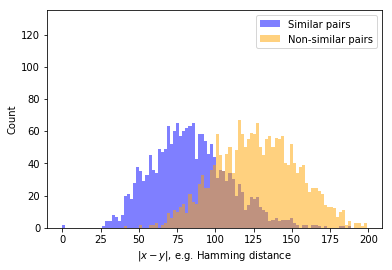

3859/3859 [==============================] - 2s 440us/step
2018-03-09 19:51:31,221 - root - DEBUG - [Iteration = 25] Training Loss = 20.993864445820094, Testing Loss = 35.43330483240116
2018-03-09 19:51:31,222 - root - DEBUG - Iteration 25 (current beta = 25251.16829404235)
Epoch 1/20
7237/7237 [==============================] - 11s 1ms/step - loss: 21.1427
Epoch 2/20
7237/7237 [==============================] - 11s 1ms/step - loss: 21.1277
Epoch 3/20
7237/7237 [==============================] - 11s 1ms/step - loss: 21.1138
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 21.1206
Epoch 5/20
7237/7237 [==============================] - 11s 1ms/step - loss: 21.1313
Epoch 6/20
7237/7237 [==============================] - 11s 1ms/step - loss: 21.0856
Epoch 7/20
7237/7237 [==============================] - 11s 1ms/step - loss: 21.1140
Epoch 8/20
7237/7237 [==============================] - 11s 1ms/step - loss: 21.1206
Epoch 9/20
7237/7237 [=======================

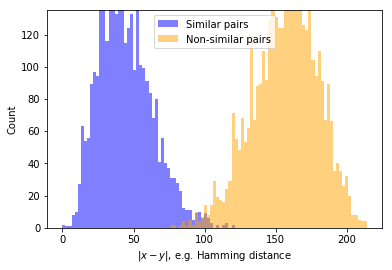

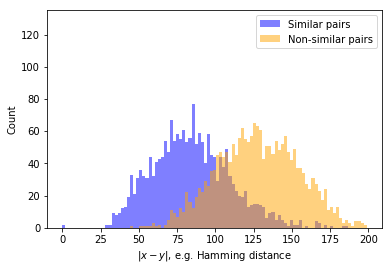

3859/3859 [==============================] - 2s 408us/step
2018-03-09 19:55:12,333 - root - DEBUG - [Iteration = 26] Training Loss = 20.91936775918855, Testing Loss = 35.32343602038381
2018-03-09 19:55:12,334 - root - DEBUG - Iteration 26 (current beta = 37876.75244106352)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 21.0428
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 21.0024
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 21.0332
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 21.0225
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.9975
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.9851
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.9781
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.9862
Epoch 9/20
7237/7237 [========================

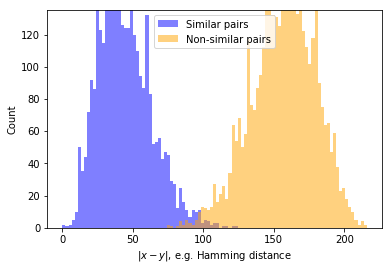

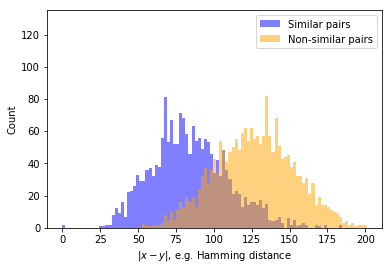

3859/3859 [==============================] - 2s 412us/step
2018-03-09 19:58:48,242 - root - DEBUG - [Iteration = 27] Training Loss = 20.87800490205519, Testing Loss = 35.48513426858547
2018-03-09 19:58:48,243 - root - DEBUG - Iteration 27 (current beta = 56815.128661595285)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.9357
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.9294
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.9133
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.8999
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.9206
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.9066
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.8900
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.8587
Epoch 9/20
7237/7237 [=======================

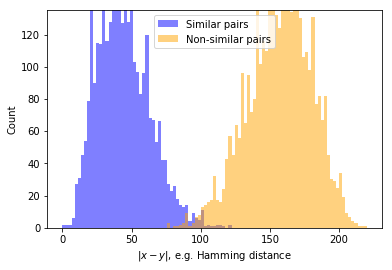

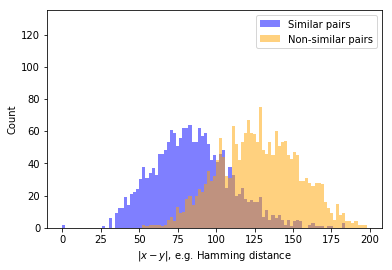

3859/3859 [==============================] - 2s 438us/step
2018-03-09 20:02:25,183 - root - DEBUG - [Iteration = 28] Training Loss = 20.751431634746666, Testing Loss = 35.49065356218744
2018-03-09 20:02:25,184 - root - DEBUG - Iteration 28 (current beta = 85222.69299239293)
Epoch 1/20
7237/7237 [==============================] - 11s 1ms/step - loss: 20.8218
Epoch 2/20
7237/7237 [==============================] - 11s 1ms/step - loss: 20.8227
Epoch 3/20
7237/7237 [==============================] - 11s 1ms/step - loss: 20.7948
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 20.8081
Epoch 5/20
7237/7237 [==============================] - 11s 1ms/step - loss: 20.7881
Epoch 6/20
7237/7237 [==============================] - 11s 1ms/step - loss: 20.8081
Epoch 7/20
7237/7237 [==============================] - 11s 1ms/step - loss: 20.7986
Epoch 8/20
7237/7237 [==============================] - 11s 1ms/step - loss: 20.7520
Epoch 9/20
7237/7237 [=======================

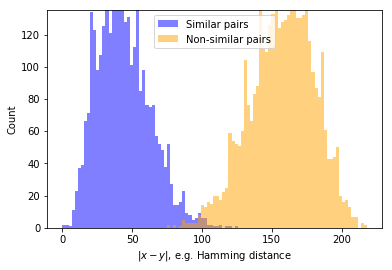

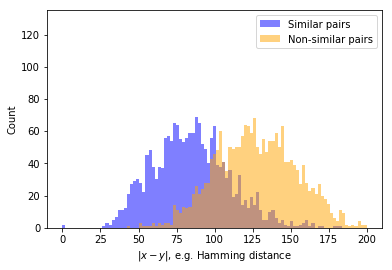

3859/3859 [==============================] - 2s 436us/step
2018-03-09 20:06:06,762 - root - DEBUG - [Iteration = 29] Training Loss = 20.645010521880696, Testing Loss = 35.44206712381245
2018-03-09 20:06:06,763 - root - DEBUG - Iteration 29 (current beta = 127834.03948858939)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.7314
Epoch 2/20
7237/7237 [==============================] - 11s 1ms/step - loss: 20.7052
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.7646
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.7351
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.7190
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.7150
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.7247
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.6728
Epoch 9/20
7237/7237 [======================

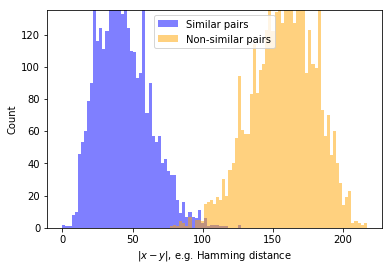

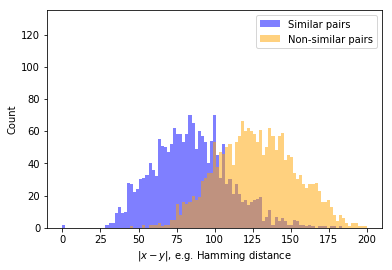

3859/3859 [==============================] - 2s 413us/step
2018-03-09 20:09:47,002 - root - DEBUG - [Iteration = 30] Training Loss = 20.54130374691805, Testing Loss = 35.47495473954121
2018-03-09 20:09:47,003 - root - DEBUG - Iteration 30 (current beta = 191751.0592328841)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.6706
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.6441
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.6446
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.6473
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.6240
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.6155
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.6194
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.5964
Epoch 9/20
7237/7237 [========================

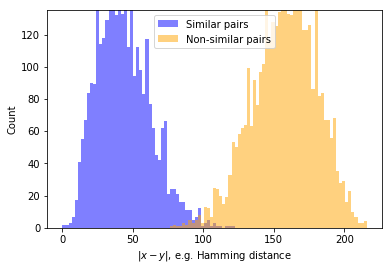

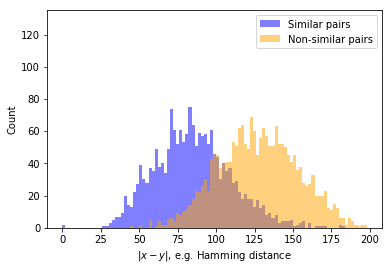

3859/3859 [==============================] - 2s 439us/step
2018-03-09 20:13:24,288 - root - DEBUG - [Iteration = 31] Training Loss = 20.475362320309994, Testing Loss = 35.545123371382275
2018-03-09 20:13:24,289 - root - DEBUG - Iteration 31 (current beta = 287626.58884932613)
Epoch 1/20
7237/7237 [==============================] - 11s 1ms/step - loss: 20.5842
Epoch 2/20
7237/7237 [==============================] - 11s 1ms/step - loss: 20.5717
Epoch 3/20
7237/7237 [==============================] - 11s 1ms/step - loss: 20.5444
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 20.5665
Epoch 5/20
7237/7237 [==============================] - 11s 1ms/step - loss: 20.5346
Epoch 6/20
7237/7237 [==============================] - 11s 1ms/step - loss: 20.5509
Epoch 7/20
7237/7237 [==============================] - 11s 1ms/step - loss: 20.5462
Epoch 8/20
7237/7237 [==============================] - 11s 1ms/step - loss: 20.5525
Epoch 9/20
7237/7237 [=====================

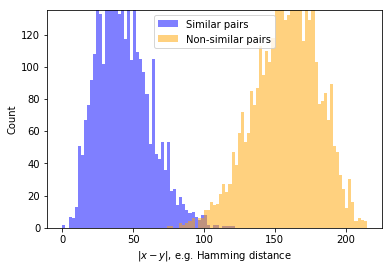

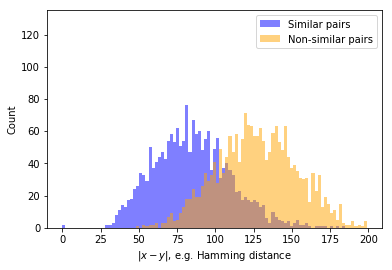

3859/3859 [==============================] - 2s 415us/step
2018-03-09 20:17:05,504 - root - DEBUG - [Iteration = 32] Training Loss = 20.393533753940243, Testing Loss = 35.518201727668185
2018-03-09 20:17:05,505 - root - DEBUG - Iteration 32 (current beta = 431439.8832739892)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.4508
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.4689
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.4774
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.4712
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.4542
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.4568
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.4412
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.4494
Epoch 9/20
7237/7237 [======================

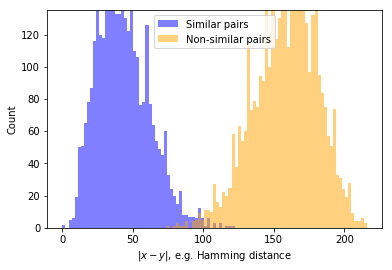

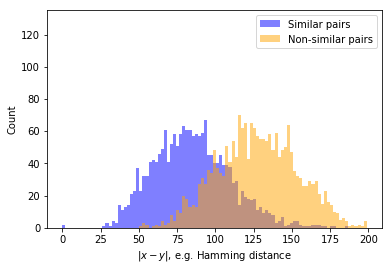

3859/3859 [==============================] - 2s 415us/step
2018-03-09 20:20:42,419 - root - DEBUG - [Iteration = 33] Training Loss = 20.362274917496062, Testing Loss = 35.49596973724642
2018-03-09 20:20:42,420 - root - DEBUG - Iteration 33 (current beta = 647159.8249109838)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.3840
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.3955
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.3886
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.3690
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.4048
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.3683
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.3840
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.3657
Epoch 9/20
7237/7237 [=======================

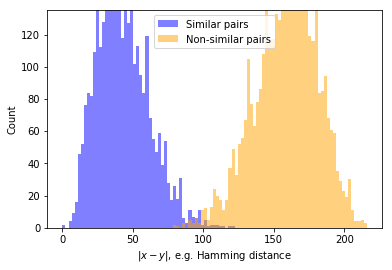

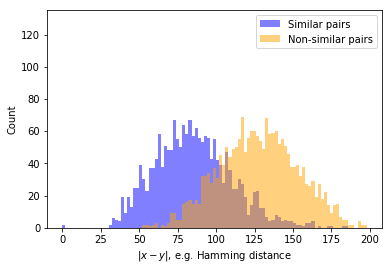

3859/3859 [==============================] - 2s 406us/step
2018-03-09 20:24:19,215 - root - DEBUG - [Iteration = 34] Training Loss = 20.19470690277477, Testing Loss = 35.49710249820501
2018-03-09 20:24:19,216 - root - DEBUG - Iteration 34 (current beta = 970739.7373664756)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.3266
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.3339
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.3059
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.3224
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.3115
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.2894
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.3070
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.2990
Epoch 9/20
7237/7237 [========================

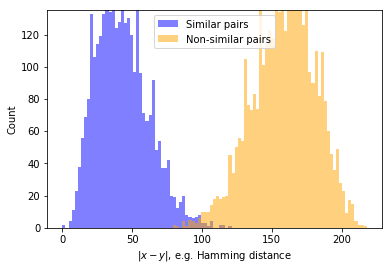

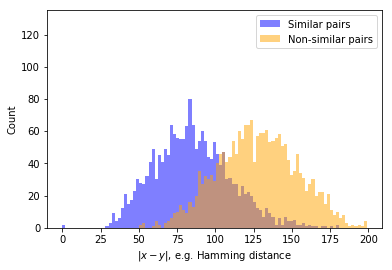

3859/3859 [==============================] - 2s 435us/step
2018-03-09 20:27:56,273 - root - DEBUG - [Iteration = 35] Training Loss = 20.18183154053034, Testing Loss = 35.57332616076008
2018-03-09 20:27:56,275 - root - DEBUG - Iteration 35 (current beta = 1456109.6060497134)
Epoch 1/20
7237/7237 [==============================] - 11s 1ms/step - loss: 20.2546
Epoch 2/20
7237/7237 [==============================] - 11s 1ms/step - loss: 20.2318
Epoch 3/20
7237/7237 [==============================] - 11s 1ms/step - loss: 20.2680
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 20.2317
Epoch 5/20
7237/7237 [==============================] - 11s 1ms/step - loss: 20.2504
Epoch 6/20
7237/7237 [==============================] - 11s 1ms/step - loss: 20.2166
Epoch 7/20
7237/7237 [==============================] - 11s 1ms/step - loss: 20.2403
Epoch 8/20
7237/7237 [==============================] - 11s 1ms/step - loss: 20.2203
Epoch 9/20
7237/7237 [=======================

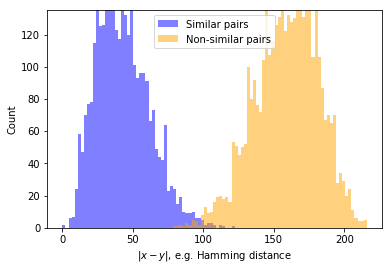

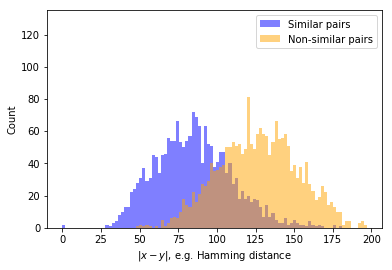

3859/3859 [==============================] - 2s 405us/step
2018-03-09 20:31:36,978 - root - DEBUG - [Iteration = 36] Training Loss = 20.09002019424407, Testing Loss = 35.58036311372756
2018-03-09 20:31:36,979 - root - DEBUG - Iteration 36 (current beta = 2184164.40907457)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.1757
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.1885
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.1772
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.1752
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.1703
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.2144
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.1643
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.1778
Epoch 9/20
7237/7237 [=========================

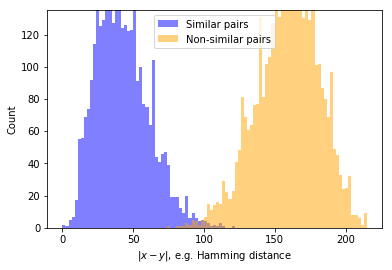

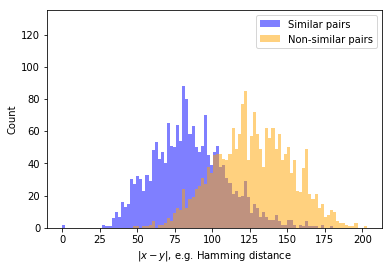

3859/3859 [==============================] - 2s 414us/step
2018-03-09 20:35:12,976 - root - DEBUG - [Iteration = 37] Training Loss = 20.057080224648487, Testing Loss = 35.57002427733046
2018-03-09 20:35:12,978 - root - DEBUG - Iteration 37 (current beta = 3276246.613611855)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.1124
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.1134
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.0960
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.1171
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.1017
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.0853
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.1100
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.1033
Epoch 9/20
7237/7237 [=======================

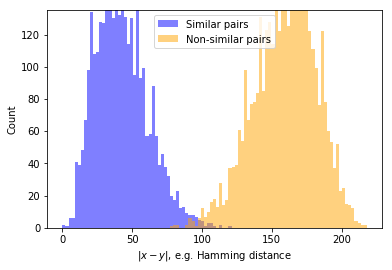

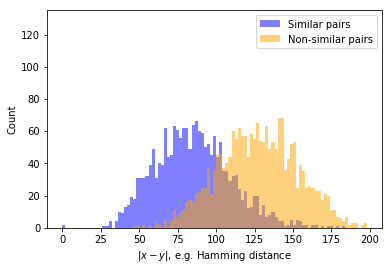

3859/3859 [==============================] - 2s 414us/step
2018-03-09 20:38:49,940 - root - DEBUG - [Iteration = 38] Training Loss = 20.01728587847677, Testing Loss = 35.561789868254216
2018-03-09 20:38:49,941 - root - DEBUG - Iteration 38 (current beta = 4914369.920417783)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.0638
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.0714
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.0476
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.0508
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.0255
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.0251
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.0475
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 20.0386
Epoch 9/20
7237/7237 [=======================

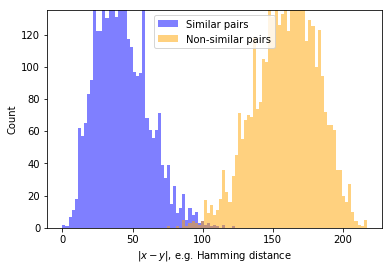

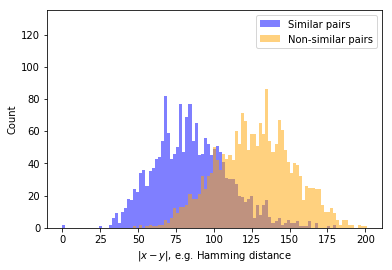

3859/3859 [==============================] - 2s 414us/step
2018-03-09 20:42:26,935 - root - DEBUG - [Iteration = 39] Training Loss = 19.952720075775712, Testing Loss = 35.56344970046748
2018-03-09 20:42:26,936 - root - DEBUG - Iteration 39 (current beta = 7371554.880626675)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.9724
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.9977
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.9705
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.9816
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.9826
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.9901
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.9655
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.9778
Epoch 9/20
7237/7237 [=======================

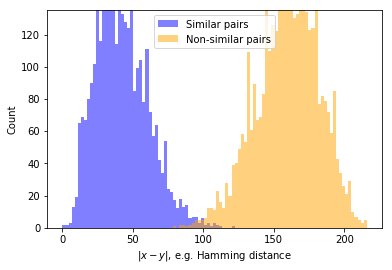

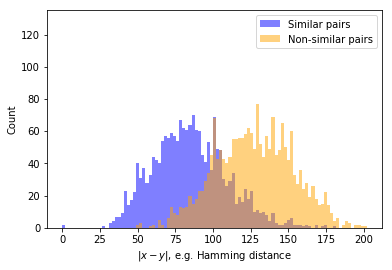

3859/3859 [==============================] - 2s 411us/step
2018-03-09 20:46:03,753 - root - DEBUG - [Iteration = 40] Training Loss = 19.865708563923093, Testing Loss = 35.50172335448491
2018-03-09 20:46:03,755 - root - DEBUG - Iteration 40 (current beta = 11057332.320940012)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.9230
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.9359
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.9173
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.9376
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.9202
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.9194
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.8686
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.8882
Epoch 9/20
7237/7237 [======================

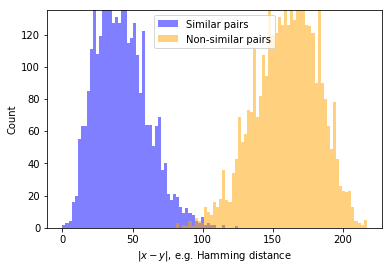

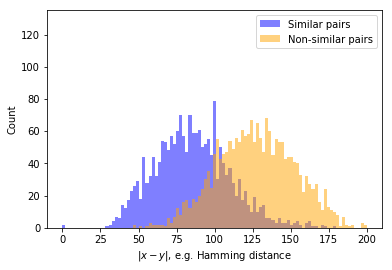

3859/3859 [==============================] - 2s 406us/step
2018-03-09 20:49:40,650 - root - DEBUG - [Iteration = 41] Training Loss = 19.822105188436957, Testing Loss = 35.53148268022263
2018-03-09 20:49:40,651 - root - DEBUG - Iteration 41 (current beta = 16585998.48141002)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.8813
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.8650
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.8518
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.8648
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.8705
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.8800
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.8345
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.8393
Epoch 9/20
7237/7237 [=======================

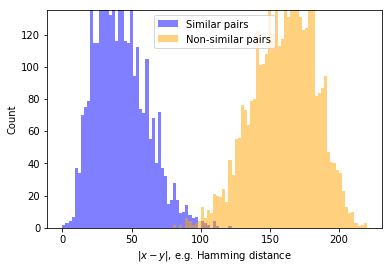

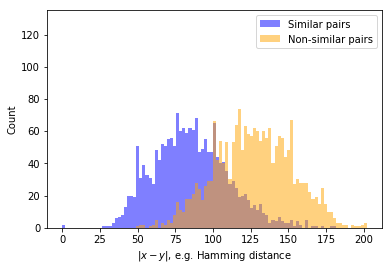

3859/3859 [==============================] - 2s 406us/step
2018-03-09 20:53:15,870 - root - DEBUG - [Iteration = 42] Training Loss = 19.80258584111472, Testing Loss = 35.58627374594185
2018-03-09 20:53:15,871 - root - DEBUG - Iteration 42 (current beta = 24878997.72211503)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.8101
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.8255
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.7839
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.7967
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.7919
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.7848
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.8090
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.7923
Epoch 9/20
7237/7237 [========================

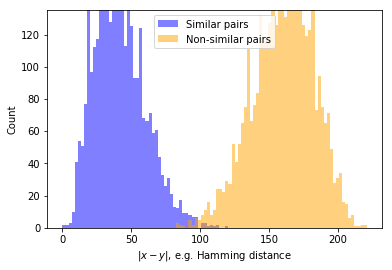

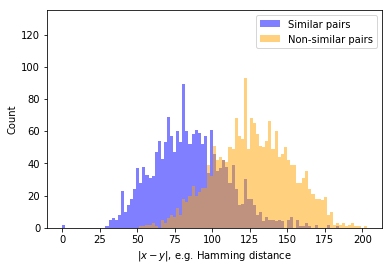

3859/3859 [==============================] - 2s 407us/step
2018-03-09 20:56:51,482 - root - DEBUG - [Iteration = 43] Training Loss = 19.70425484966833, Testing Loss = 35.53926249037261
2018-03-09 20:56:51,482 - root - DEBUG - Iteration 43 (current beta = 37318496.583172545)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.7606
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.7626
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.7603
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.7467
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.7563
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.7442
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.7536
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.7396
Epoch 9/20
7237/7237 [=======================

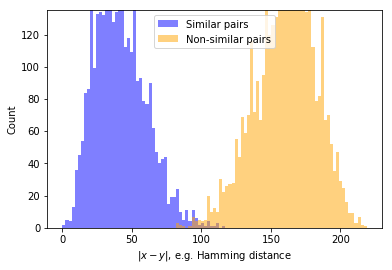

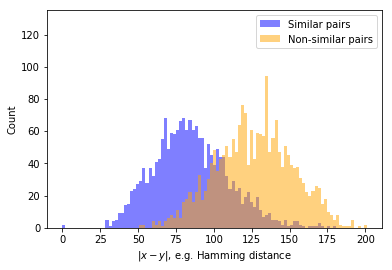

3859/3859 [==============================] - 2s 405us/step
2018-03-09 21:00:27,714 - root - DEBUG - [Iteration = 44] Training Loss = 19.67472499039879, Testing Loss = 35.610761727963
2018-03-09 21:00:27,715 - root - DEBUG - Iteration 44 (current beta = 55977744.87475882)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.7022
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.7160
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.7086
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.6926
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.6833
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.6786
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.6964
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.7022
Epoch 9/20
7237/7237 [==========================

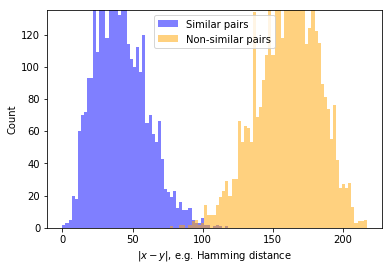

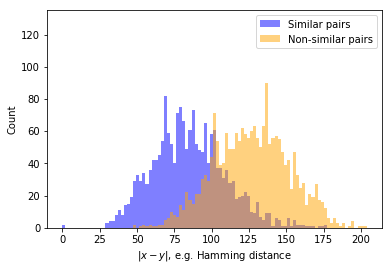

3859/3859 [==============================] - 2s 414us/step
2018-03-09 21:04:03,109 - root - DEBUG - [Iteration = 45] Training Loss = 19.58953041857047, Testing Loss = 35.624481466589394
2018-03-09 21:04:03,110 - root - DEBUG - Iteration 45 (current beta = 83966617.31213823)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.6516
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.6606
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.6635
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.6630
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.6611
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.6422
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.6363
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.6354
Epoch 9/20
7237/7237 [=======================

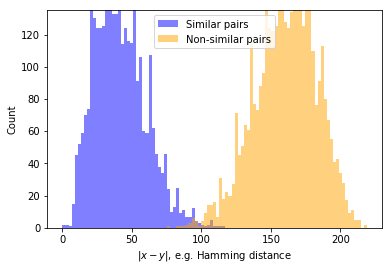

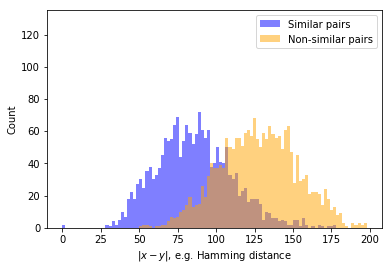

3859/3859 [==============================] - 2s 411us/step
2018-03-09 21:07:40,270 - root - DEBUG - [Iteration = 46] Training Loss = 19.58135218206519, Testing Loss = 35.58931141982087
2018-03-09 21:07:40,271 - root - DEBUG - Iteration 46 (current beta = 125949925.96820734)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.5946
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.6214
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.6139
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.6233
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.5952
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.5955
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.6073
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.5973
Epoch 9/20
7237/7237 [=======================

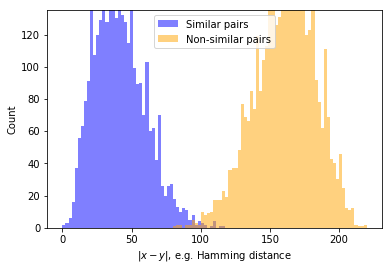

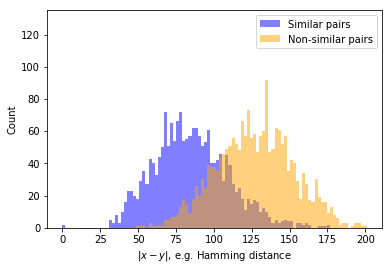

3859/3859 [==============================] - 2s 411us/step
2018-03-09 21:11:16,223 - root - DEBUG - [Iteration = 47] Training Loss = 19.523469579471843, Testing Loss = 35.61110586624561
2018-03-09 21:11:16,224 - root - DEBUG - Iteration 47 (current beta = 188924888.952311)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.5601
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.5670
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.5477
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.5602
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.5707
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.5454
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.5395
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.5482
Epoch 9/20
7237/7237 [========================

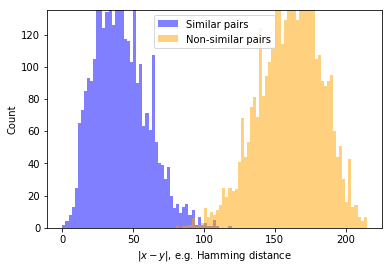

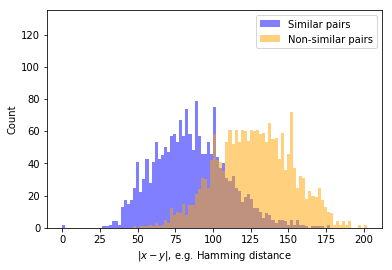

3859/3859 [==============================] - 2s 412us/step
2018-03-09 21:14:53,121 - root - DEBUG - [Iteration = 48] Training Loss = 19.459723906769383, Testing Loss = 35.5976455255505
2018-03-09 21:14:53,122 - root - DEBUG - Iteration 48 (current beta = 283387333.4284665)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.5022
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.5210
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.5220
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.4963
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.5188
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.5169
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.4898
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.4720
Epoch 9/20
7237/7237 [========================

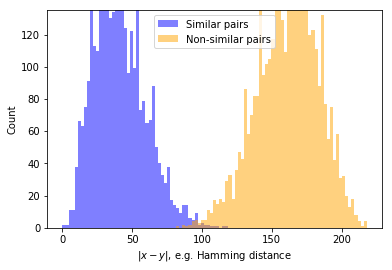

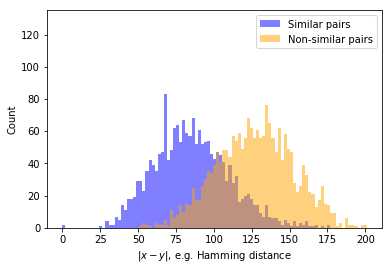

3859/3859 [==============================] - 2s 441us/step
2018-03-09 21:18:30,313 - root - DEBUG - [Iteration = 49] Training Loss = 19.424745986981172, Testing Loss = 35.60863438230872
2018-03-09 21:18:30,314 - root - DEBUG - Iteration 49 (current beta = 425081000.1426997)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.4712
Epoch 2/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.4631
Epoch 3/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.4695
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.4622
Epoch 5/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.4598
Epoch 6/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.4500
Epoch 7/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.4533
Epoch 8/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.4395
Epoch 9/20
7237/7237 [=======================

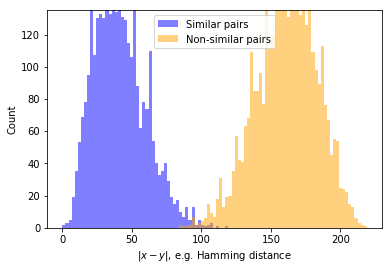

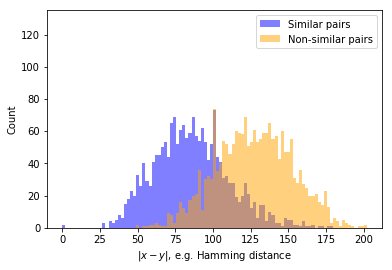

3859/3859 [==============================] - 2s 412us/step
2018-03-09 21:22:10,979 - root - DEBUG - [Iteration = 50] Training Loss = 19.415024900495702, Testing Loss = 35.630061084107744
2018-03-09 21:22:10,980 - root - DEBUG - Iteration 50 (current beta = 637621500.2140496)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.4426
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.4363
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.4262
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.4322
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.4190
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.4086
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.4152
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.4230
Epoch 9/20
7237/7237 [======================

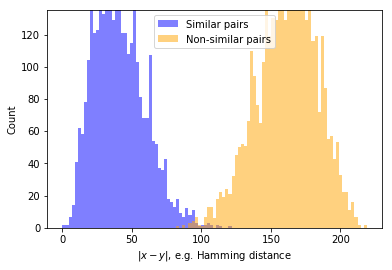

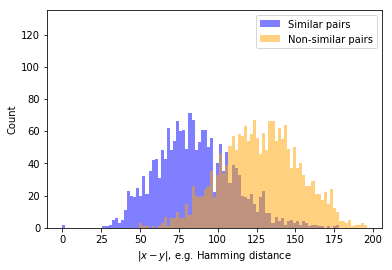

3859/3859 [==============================] - 2s 435us/step
2018-03-09 21:25:48,227 - root - DEBUG - [Iteration = 51] Training Loss = 19.359307562232562, Testing Loss = 35.60088007349398
2018-03-09 21:25:48,228 - root - DEBUG - Iteration 51 (current beta = 956432250.3210744)
Epoch 1/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.3913
Epoch 2/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.4130
Epoch 3/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.3883
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.3889
Epoch 5/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.3830
Epoch 6/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.3674
Epoch 7/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.3615
Epoch 8/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.3912
Epoch 9/20
7237/7237 [=======================

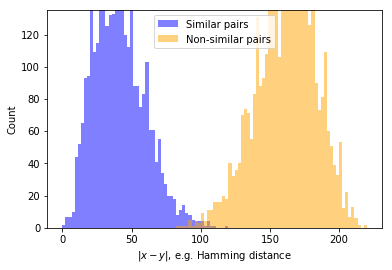

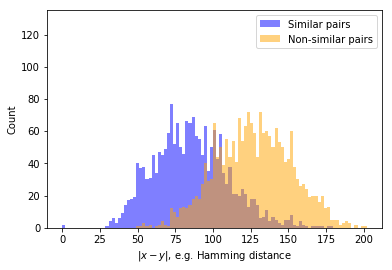

3859/3859 [==============================] - 2s 440us/step
2018-03-09 21:29:29,569 - root - DEBUG - [Iteration = 52] Training Loss = 19.328042451264995, Testing Loss = 35.643768178579506
2018-03-09 21:29:29,570 - root - DEBUG - Iteration 52 (current beta = 1434648375.4816115)
Epoch 1/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.3408
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.3450
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.3158
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.3400
Epoch 5/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.3495
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.3273
Epoch 7/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.3438
Epoch 8/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.3331
Epoch 9/20
7237/7237 [=====================

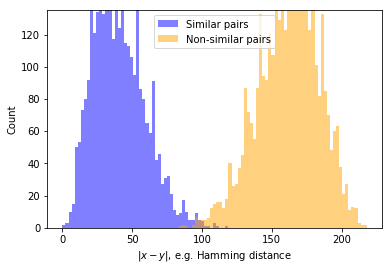

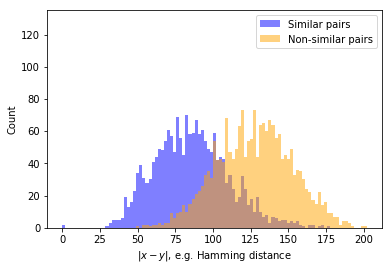

3859/3859 [==============================] - 2s 438us/step
2018-03-09 21:33:10,840 - root - DEBUG - [Iteration = 53] Training Loss = 19.257498579524707, Testing Loss = 35.55726570204522
2018-03-09 21:33:10,841 - root - DEBUG - Iteration 53 (current beta = 2151972563.2224174)
Epoch 1/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.2778
Epoch 2/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.3049
Epoch 3/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.3041
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.2931
Epoch 5/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.2860
Epoch 6/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.3033
Epoch 7/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.2956
Epoch 8/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.3020
Epoch 9/20
7237/7237 [======================

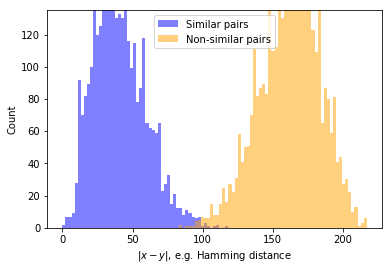

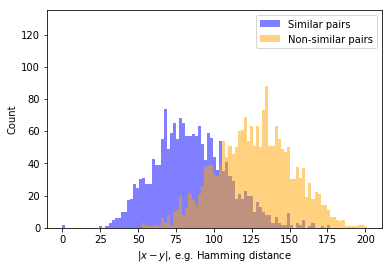

3859/3859 [==============================] - 2s 444us/step
2018-03-09 21:36:52,500 - root - DEBUG - [Iteration = 54] Training Loss = 19.21576682529974, Testing Loss = 35.657455119607235
2018-03-09 21:36:52,501 - root - DEBUG - Iteration 54 (current beta = 3227958844.833626)
Epoch 1/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.2750
Epoch 2/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.2838
Epoch 3/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.2587
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.2373
Epoch 5/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.2493
Epoch 6/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.2555
Epoch 7/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.2467
Epoch 8/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.2640
Epoch 9/20
7237/7237 [=======================

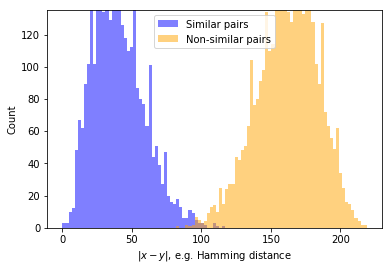

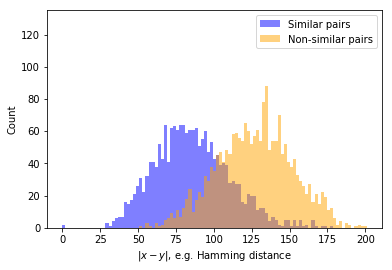

3859/3859 [==============================] - 2s 439us/step
2018-03-09 21:40:34,135 - root - DEBUG - [Iteration = 55] Training Loss = 19.178131890491308, Testing Loss = 35.61258528967168
2018-03-09 21:40:34,136 - root - DEBUG - Iteration 55 (current beta = 4841938267.250439)
Epoch 1/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.2139
Epoch 2/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.2260
Epoch 3/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.2182
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.2291
Epoch 5/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.2016
Epoch 6/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.2155
Epoch 7/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.1848
Epoch 8/20
7237/7237 [==============================] - 11s 1ms/step - loss: 19.2152
Epoch 9/20
7237/7237 [=======================

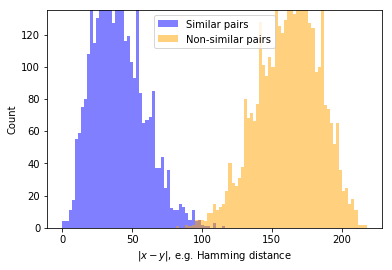

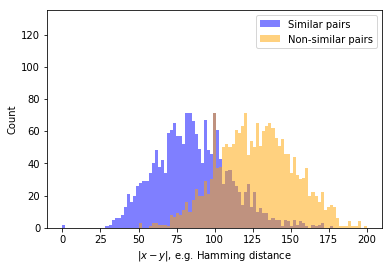

3859/3859 [==============================] - 2s 408us/step
2018-03-09 21:44:15,095 - root - DEBUG - [Iteration = 56] Training Loss = 19.116732582987318, Testing Loss = 35.62666343685011
2018-03-09 21:44:15,096 - root - DEBUG - Iteration 56 (current beta = 7262907400.875658)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.1860
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.2038
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.2044
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.1832
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.1963
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.1873
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.1921
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.1817
Epoch 9/20
7237/7237 [=======================

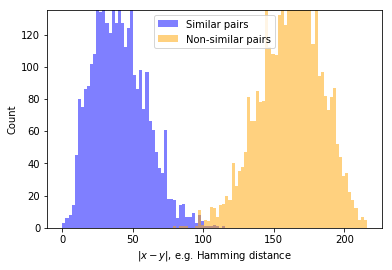

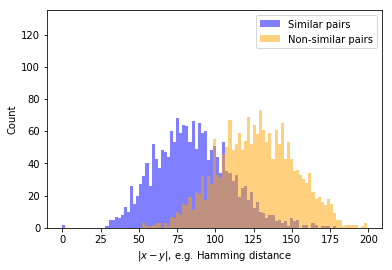

3859/3859 [==============================] - 2s 408us/step
2018-03-09 21:47:50,495 - root - DEBUG - [Iteration = 57] Training Loss = 19.09500623787077, Testing Loss = 35.6948514549372
2018-03-09 21:47:50,496 - root - DEBUG - Iteration 57 (current beta = 10894361101.313488)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.1635
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.1348
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.1557
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.1485
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.1490
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.1492
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.1309
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.1284
Epoch 9/20
7237/7237 [========================

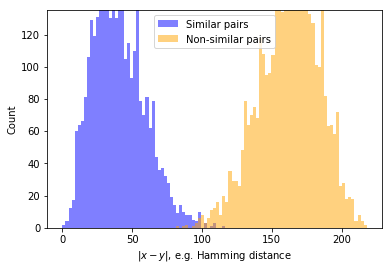

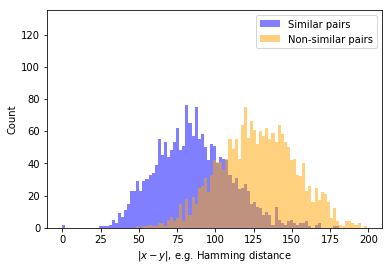

3859/3859 [==============================] - 2s 411us/step
2018-03-09 21:51:26,147 - root - DEBUG - [Iteration = 58] Training Loss = 19.076360471640335, Testing Loss = 35.607142277164264
2018-03-09 21:51:26,148 - root - DEBUG - Iteration 58 (current beta = 16341541651.970232)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.1091
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.1094
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.0987
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.1229
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.1202
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.0988
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.1156
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.1014
Epoch 9/20
7237/7237 [=====================

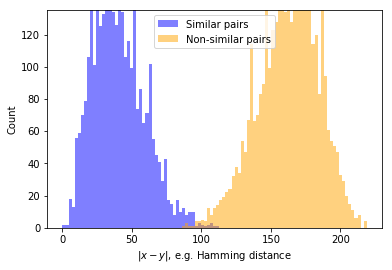

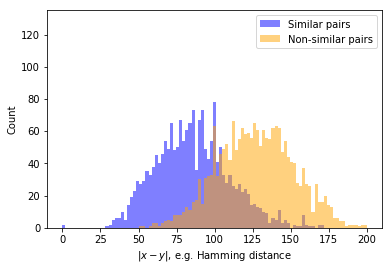

3859/3859 [==============================] - 2s 404us/step
2018-03-09 21:55:02,079 - root - DEBUG - [Iteration = 59] Training Loss = 19.051651555990766, Testing Loss = 35.617645018519006
2018-03-09 21:55:02,080 - root - DEBUG - Iteration 59 (current beta = 24512312477.95535)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.0616
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.0714
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.0734
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.0661
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.0758
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.0701
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.0524
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.0891
Epoch 9/20
7237/7237 [======================

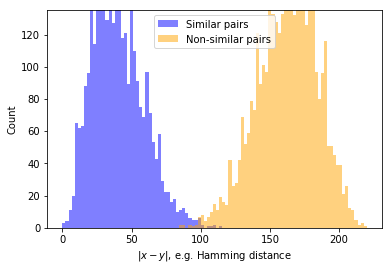

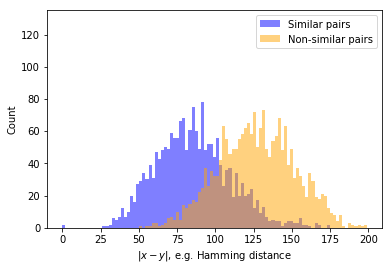

3859/3859 [==============================] - 2s 410us/step
2018-03-09 21:58:37,319 - root - DEBUG - [Iteration = 60] Training Loss = 19.04741756438682, Testing Loss = 35.683313378647654
2018-03-09 21:58:37,320 - root - DEBUG - Iteration 60 (current beta = 36768468716.93302)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.0556
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.0452
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.0517
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.0553
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.0535
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.0285
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.0276
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.0141
Epoch 9/20
7237/7237 [=======================

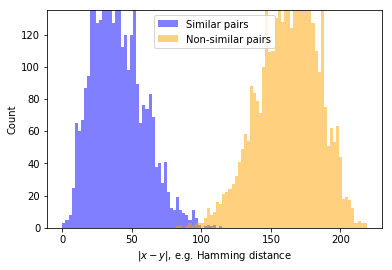

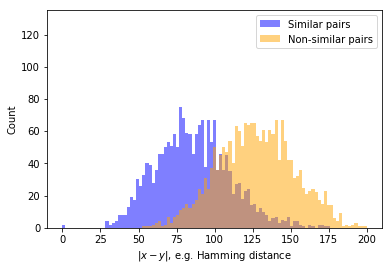

3859/3859 [==============================] - 2s 404us/step
2018-03-09 22:02:13,763 - root - DEBUG - [Iteration = 61] Training Loss = 18.978326246457417, Testing Loss = 35.58540398013749
2018-03-09 22:02:13,764 - root - DEBUG - Iteration 61 (current beta = 55152703075.399536)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.0230
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.9924
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.9994
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.9978
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.0016
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.9916
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 19.0043
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.9893
Epoch 9/20
7237/7237 [======================

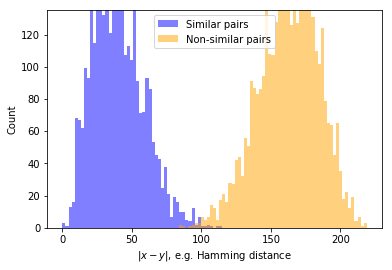

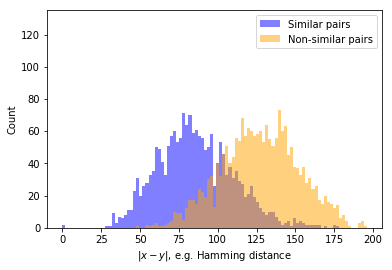

3859/3859 [==============================] - 2s 438us/step
2018-03-09 22:05:49,730 - root - DEBUG - [Iteration = 62] Training Loss = 18.939642106727355, Testing Loss = 35.620499775736526
2018-03-09 22:05:49,731 - root - DEBUG - Iteration 62 (current beta = 82729054613.0993)
Epoch 1/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.9935
Epoch 2/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.9830
Epoch 3/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.9529
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.9522
Epoch 5/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.9876
Epoch 6/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.9605
Epoch 7/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.9644
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.9766
Epoch 9/20
7237/7237 [=======================

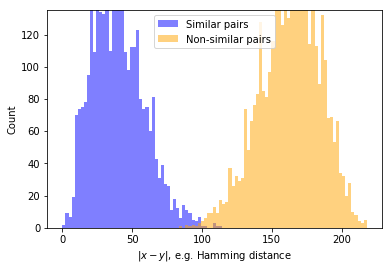

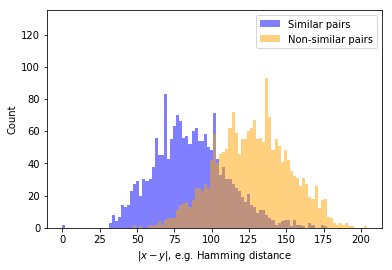

3859/3859 [==============================] - 2s 412us/step
2018-03-09 22:09:30,268 - root - DEBUG - [Iteration = 63] Training Loss = 18.882170091499624, Testing Loss = 35.59357806727441
2018-03-09 22:09:30,269 - root - DEBUG - Iteration 63 (current beta = 124093581919.64896)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.9389
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.9332
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.9373
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.9542
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.9319
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.9381
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.9336
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.9514
Epoch 9/20
7237/7237 [======================

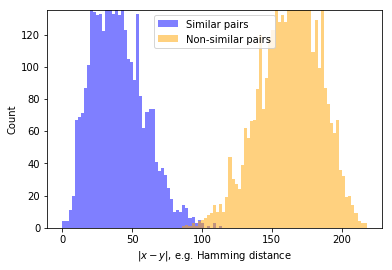

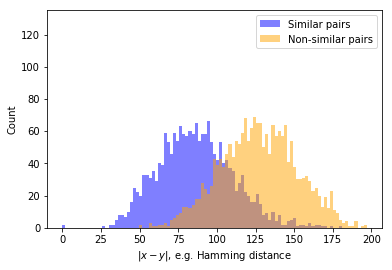

3859/3859 [==============================] - 2s 434us/step
2018-03-09 22:13:07,146 - root - DEBUG - [Iteration = 64] Training Loss = 18.89023939067856, Testing Loss = 35.66980236841317
2018-03-09 22:13:07,147 - root - DEBUG - Iteration 64 (current beta = 186140372879.47345)
Epoch 1/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.9197
Epoch 2/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.9281
Epoch 3/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.8996
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.9132
Epoch 5/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.9163
Epoch 6/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.9130
Epoch 7/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.8999
Epoch 8/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.9003
Epoch 9/20
7237/7237 [=======================

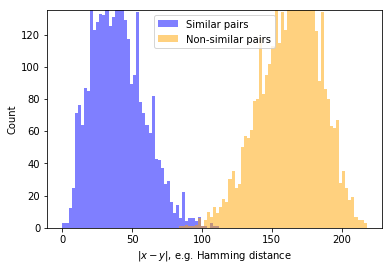

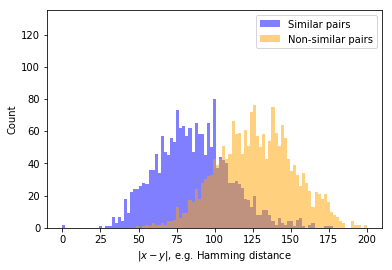

3859/3859 [==============================] - 2s 413us/step
2018-03-09 22:16:48,264 - root - DEBUG - [Iteration = 65] Training Loss = 18.83649873107577, Testing Loss = 35.57681768921009
2018-03-09 22:16:48,265 - root - DEBUG - Iteration 65 (current beta = 279210559319.2102)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.8624
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.8691
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.8712
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.8935
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.8873
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.8802
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.8629
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.8736
Epoch 9/20
7237/7237 [========================

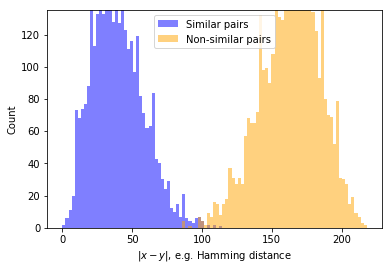

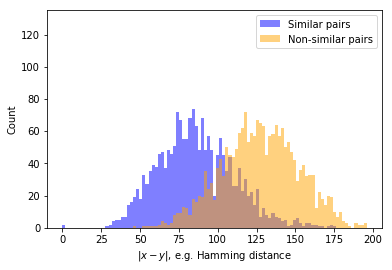

3859/3859 [==============================] - 2s 413us/step
2018-03-09 22:20:25,029 - root - DEBUG - [Iteration = 66] Training Loss = 18.823813073128086, Testing Loss = 35.674902742716526
2018-03-09 22:20:25,029 - root - DEBUG - Iteration 66 (current beta = 418815838978.8153)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.8587
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.8382
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.8500
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.8444
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.8362
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.8561
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.8283
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.8551
Epoch 9/20
7237/7237 [======================

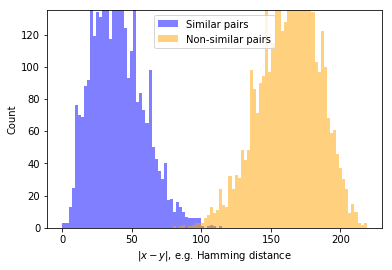

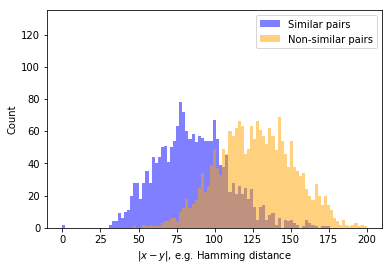

3859/3859 [==============================] - 2s 413us/step
2018-03-09 22:24:01,789 - root - DEBUG - [Iteration = 67] Training Loss = 18.81748580016763, Testing Loss = 35.63870215434489
2018-03-09 22:24:01,790 - root - DEBUG - Iteration 67 (current beta = 628223758468.2229)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.8244
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.8072
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.8130
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.8119
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.8160
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.8361
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.8083
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.8056
Epoch 9/20
7237/7237 [========================

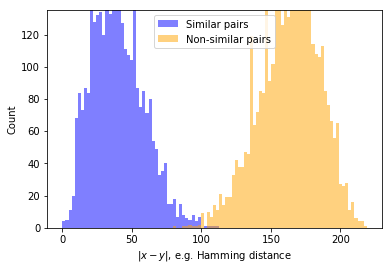

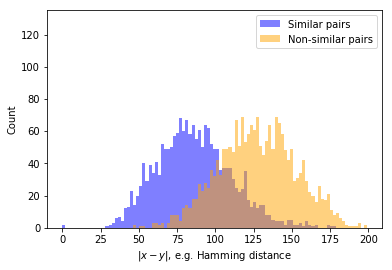

3859/3859 [==============================] - 2s 432us/step
2018-03-09 22:27:38,774 - root - DEBUG - [Iteration = 68] Training Loss = 18.795599135242973, Testing Loss = 35.655369190948555
2018-03-09 22:27:38,775 - root - DEBUG - Iteration 68 (current beta = 942335637702.3344)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.7795
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.7798
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.7718
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.7788
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.7749
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.7718
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.7914
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.7725
Epoch 9/20
7237/7237 [======================

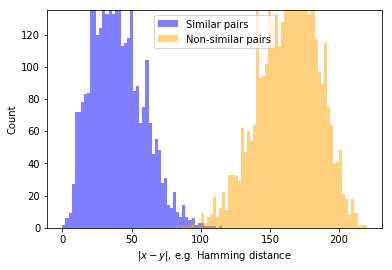

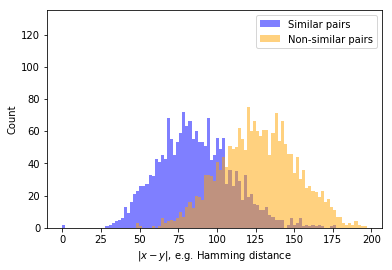

3859/3859 [==============================] - 2s 440us/step
2018-03-09 22:31:19,015 - root - DEBUG - [Iteration = 69] Training Loss = 18.7323150021341, Testing Loss = 35.61509887317698
2018-03-09 22:31:19,017 - root - DEBUG - Iteration 69 (current beta = 1413503456553.5015)
Epoch 1/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.7535
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.7575
Epoch 3/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.7479
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.7616
Epoch 5/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.7531
Epoch 6/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.7378
Epoch 7/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.7387
Epoch 8/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.7492
Epoch 9/20
7237/7237 [========================

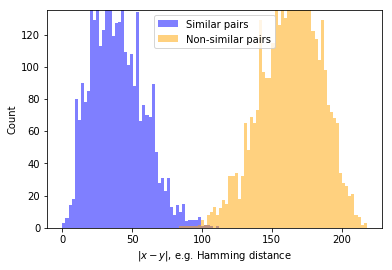

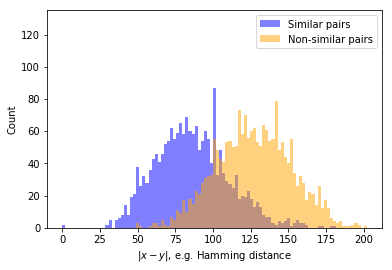

3859/3859 [==============================] - 2s 414us/step
2018-03-09 22:35:00,178 - root - DEBUG - [Iteration = 70] Training Loss = 18.674110221915505, Testing Loss = 35.71976373281526
2018-03-09 22:35:00,179 - root - DEBUG - Iteration 70 (current beta = 2120255184830.2522)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.7330
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.7305
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.7354
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.7332
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.7085
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.7227
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.7232
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.7198
Epoch 9/20
7237/7237 [======================

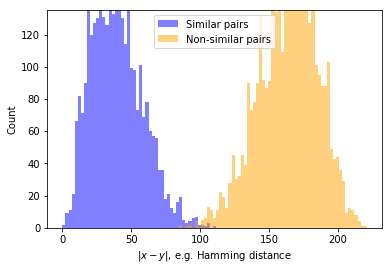

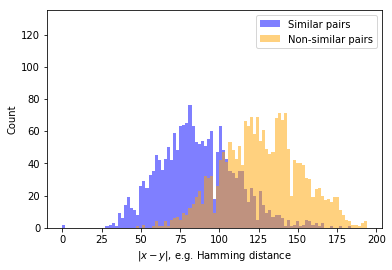

3859/3859 [==============================] - 2s 415us/step
2018-03-09 22:38:37,356 - root - DEBUG - [Iteration = 71] Training Loss = 18.669735833460972, Testing Loss = 35.669380389152025
2018-03-09 22:38:37,356 - root - DEBUG - Iteration 71 (current beta = 3180382777245.3784)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.6993
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.6721
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.7041
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.7125
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.6913
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.6902
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.6833
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.6955
Epoch 9/20
7237/7237 [=====================

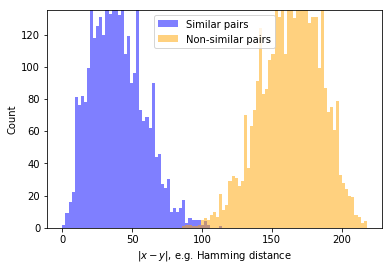

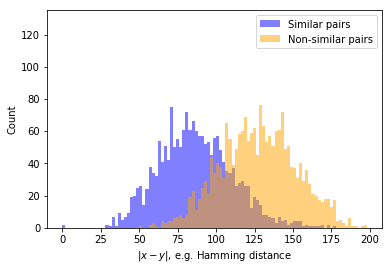

3859/3859 [==============================] - 2s 441us/step
2018-03-09 22:42:14,222 - root - DEBUG - [Iteration = 72] Training Loss = 18.66107883007961, Testing Loss = 35.76177572827167
2018-03-09 22:42:14,223 - root - DEBUG - Iteration 72 (current beta = 4770574165868.067)
Epoch 1/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.6921
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.6762
Epoch 3/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.6670
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.6690
Epoch 5/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.6607
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.6693
Epoch 7/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.6670
Epoch 8/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.6688
Epoch 9/20
7237/7237 [========================

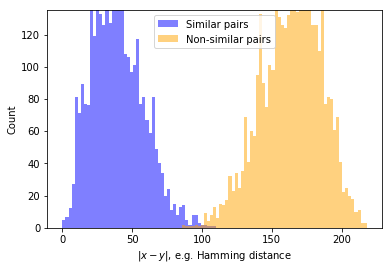

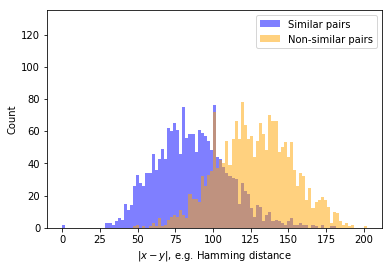

3859/3859 [==============================] - 2s 437us/step
2018-03-09 22:45:55,729 - root - DEBUG - [Iteration = 73] Training Loss = 18.61180069183997, Testing Loss = 35.64795048850347
2018-03-09 22:45:55,730 - root - DEBUG - Iteration 73 (current beta = 7155861248802.102)
Epoch 1/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.6484
Epoch 2/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.6500
Epoch 3/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.6471
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.6322
Epoch 5/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.6568
Epoch 6/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.6586
Epoch 7/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.6322
Epoch 8/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.6496
Epoch 9/20
7237/7237 [========================

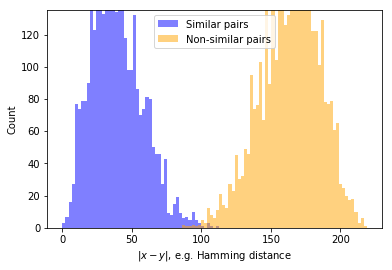

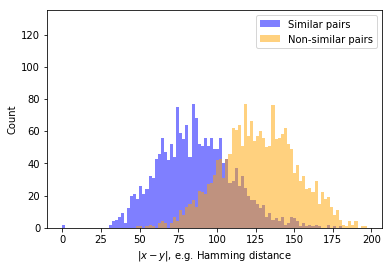

3859/3859 [==============================] - 2s 438us/step
2018-03-09 22:49:37,430 - root - DEBUG - [Iteration = 74] Training Loss = 18.57443672829576, Testing Loss = 35.708748335787654
2018-03-09 22:49:37,431 - root - DEBUG - Iteration 74 (current beta = 10733791873203.152)
Epoch 1/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.6265
Epoch 2/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.6048
Epoch 3/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.6172
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.6359
Epoch 5/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.6235
Epoch 6/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.5999
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.6129
Epoch 8/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.5927
Epoch 9/20
7237/7237 [======================

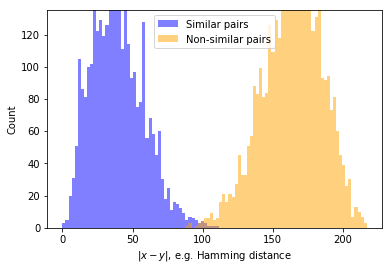

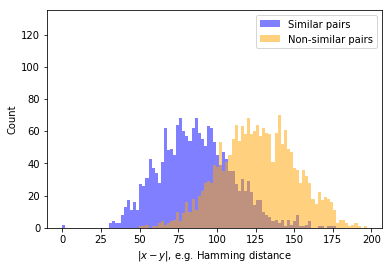

3859/3859 [==============================] - 2s 416us/step
2018-03-09 22:53:17,929 - root - DEBUG - [Iteration = 75] Training Loss = 18.56298091264329, Testing Loss = 35.791395521991824
2018-03-09 22:53:17,930 - root - DEBUG - Iteration 75 (current beta = 16100687809804.729)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5952
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5929
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5884
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5989
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5991
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5671
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5827
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.6084
Epoch 9/20
7237/7237 [======================

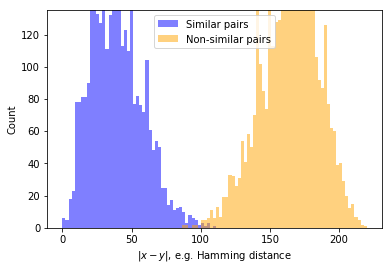

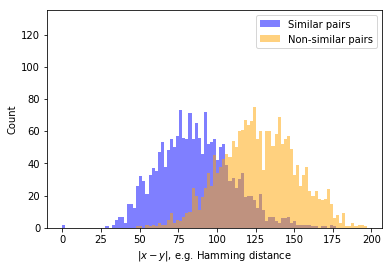

3859/3859 [==============================] - 2s 414us/step
2018-03-09 22:56:55,005 - root - DEBUG - [Iteration = 76] Training Loss = 18.53045667771132, Testing Loss = 35.67699017343079
2018-03-09 22:56:55,006 - root - DEBUG - Iteration 76 (current beta = 24151031714707.094)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5812
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5846
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5676
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5730
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5611
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5539
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5727
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5745
Epoch 9/20
7237/7237 [=======================

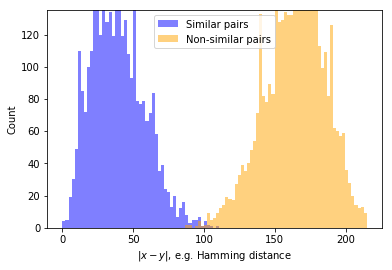

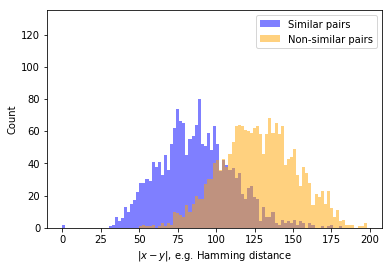

3859/3859 [==============================] - 2s 411us/step
2018-03-09 23:00:31,770 - root - DEBUG - [Iteration = 77] Training Loss = 18.515315894281994, Testing Loss = 35.72290415639054
2018-03-09 23:00:31,771 - root - DEBUG - Iteration 77 (current beta = 36226547572060.64)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5407
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5501
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5450
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5364
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5287
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5245
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5544
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5404
Epoch 9/20
7237/7237 [=======================

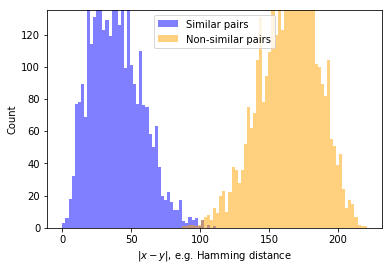

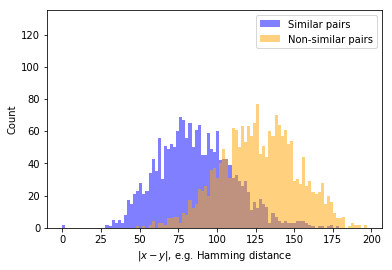

3859/3859 [==============================] - 2s 412us/step
2018-03-09 23:04:08,871 - root - DEBUG - [Iteration = 78] Training Loss = 18.465778240828747, Testing Loss = 35.63397072176453
2018-03-09 23:04:08,872 - root - DEBUG - Iteration 78 (current beta = 54339821358090.96)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5109
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5099
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5182
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5104
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5358
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5083
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5060
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5013
Epoch 9/20
7237/7237 [=======================

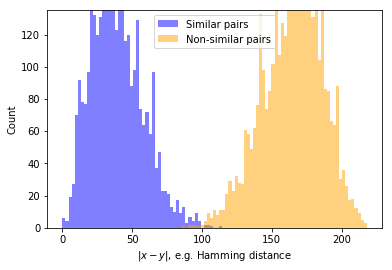

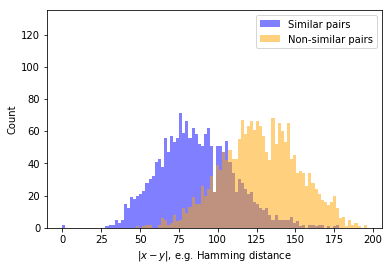

3859/3859 [==============================] - 2s 411us/step
2018-03-09 23:07:45,546 - root - DEBUG - [Iteration = 79] Training Loss = 18.478628170165763, Testing Loss = 35.621984036977686
2018-03-09 23:07:45,547 - root - DEBUG - Iteration 79 (current beta = 81509732037136.44)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4962
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4808
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4785
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4981
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4916
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5122
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4820
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.5131
Epoch 9/20
7237/7237 [======================

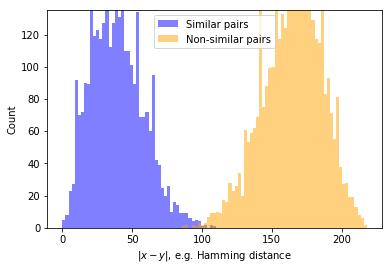

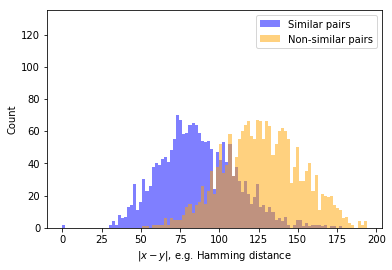

3859/3859 [==============================] - 2s 415us/step
2018-03-09 23:11:22,455 - root - DEBUG - [Iteration = 80] Training Loss = 18.434027552522313, Testing Loss = 35.71691840854634
2018-03-09 23:11:22,456 - root - DEBUG - Iteration 80 (current beta = 122264598055704.66)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4950
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4844
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4721
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4785
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4654
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4698
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4749
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4627
Epoch 9/20
7237/7237 [======================

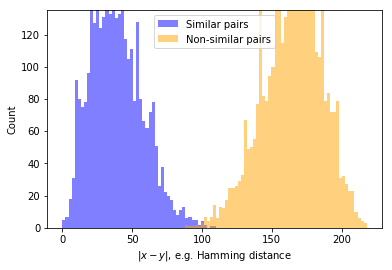

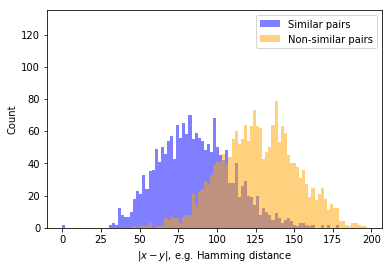

3859/3859 [==============================] - 2s 404us/step
2018-03-09 23:14:59,546 - root - DEBUG - [Iteration = 81] Training Loss = 18.419946202194723, Testing Loss = 35.722919718160874
2018-03-09 23:14:59,547 - root - DEBUG - Iteration 81 (current beta = 183396897083557.0)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4590
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4720
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4536
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4418
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4621
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4826
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4534
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4523
Epoch 9/20
7237/7237 [======================

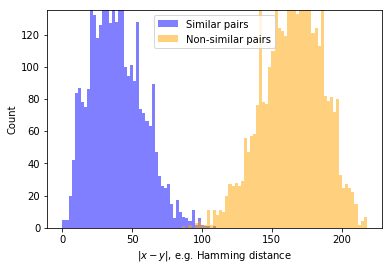

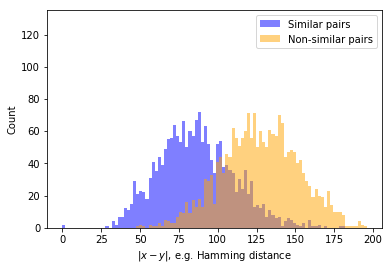

3859/3859 [==============================] - 2s 407us/step
2018-03-09 23:18:35,158 - root - DEBUG - [Iteration = 82] Training Loss = 18.365798542936716, Testing Loss = 35.68825706566946
2018-03-09 23:18:35,159 - root - DEBUG - Iteration 82 (current beta = 275095345625335.5)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4205
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4254
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4319
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4250
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4242
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4346
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4259
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4192
Epoch 9/20
7237/7237 [=======================

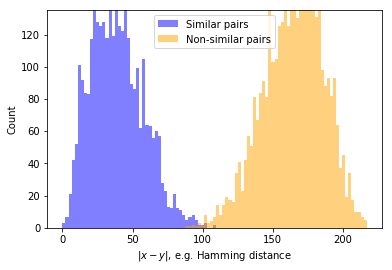

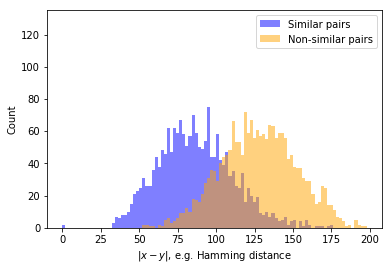

3859/3859 [==============================] - 2s 408us/step
2018-03-09 23:22:10,948 - root - DEBUG - [Iteration = 83] Training Loss = 18.354990252707896, Testing Loss = 35.65791028100118
2018-03-09 23:22:10,949 - root - DEBUG - Iteration 83 (current beta = 412643018438003.25)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4076
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4078
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4032
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4108
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3914
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3959
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4086
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4049
Epoch 9/20
7237/7237 [======================

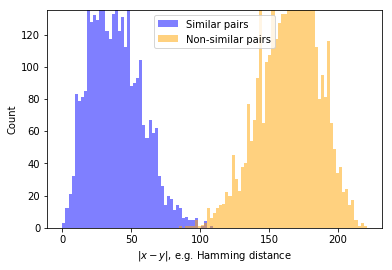

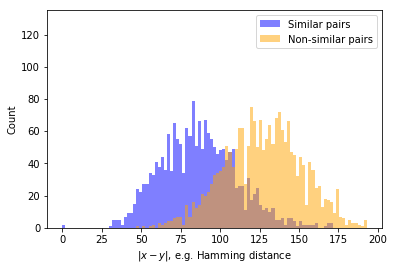

3859/3859 [==============================] - 2s 404us/step
2018-03-09 23:25:46,519 - root - DEBUG - [Iteration = 84] Training Loss = 18.331765802818815, Testing Loss = 35.67760580517091
2018-03-09 23:25:46,520 - root - DEBUG - Iteration 84 (current beta = 618964527657004.9)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3743
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3909
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3880
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3839
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.4148
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3762
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3828
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3697
Epoch 9/20
7237/7237 [=======================

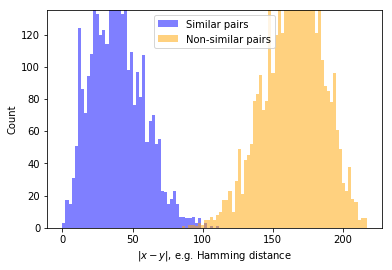

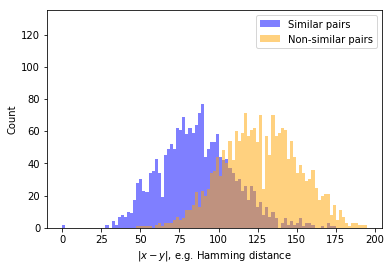

3859/3859 [==============================] - 2s 407us/step
2018-03-09 23:29:21,965 - root - DEBUG - [Iteration = 85] Training Loss = 18.36056119443238, Testing Loss = 35.72499977402441
2018-03-09 23:29:21,966 - root - DEBUG - Iteration 85 (current beta = 928446791485507.2)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3628
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3592
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3558
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3714
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3571
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3653
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3552
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3510
Epoch 9/20
7237/7237 [========================

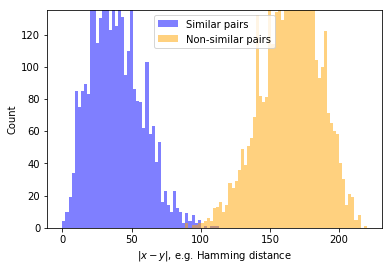

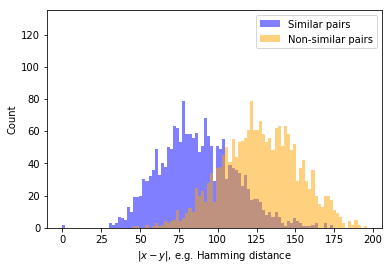

3859/3859 [==============================] - 2s 406us/step
2018-03-09 23:32:57,712 - root - DEBUG - [Iteration = 86] Training Loss = 18.30718997319759, Testing Loss = 35.68425461491577
2018-03-09 23:32:57,713 - root - DEBUG - Iteration 86 (current beta = 1392670187228261.0)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3295
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3342
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3531
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3436
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3293
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3259
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3504
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3264
Epoch 9/20
7237/7237 [=======================

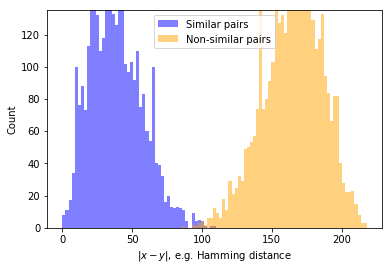

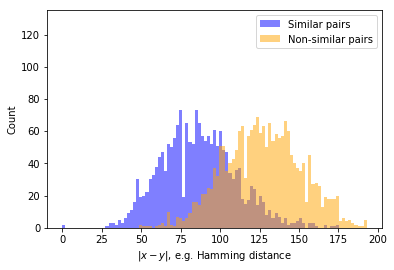

3859/3859 [==============================] - 2s 410us/step
2018-03-09 23:36:33,506 - root - DEBUG - [Iteration = 87] Training Loss = 18.27753767322173, Testing Loss = 35.743808804660546
2018-03-09 23:36:33,507 - root - DEBUG - Iteration 87 (current beta = 2089005280842391.5)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3138
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3197
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3237
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3247
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3146
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3169
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3081
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.3188
Epoch 9/20
7237/7237 [======================

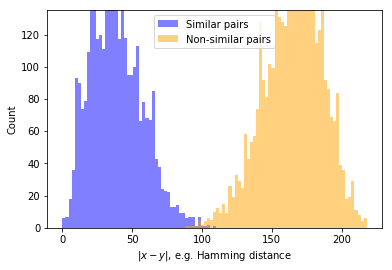

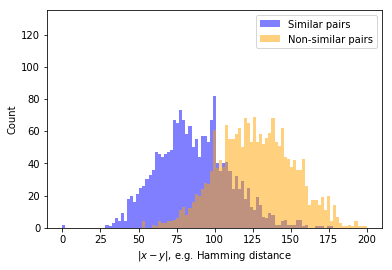

3859/3859 [==============================] - 2s 439us/step
2018-03-09 23:40:10,755 - root - DEBUG - [Iteration = 88] Training Loss = 18.262180252465257, Testing Loss = 35.740089359664026
2018-03-09 23:40:10,756 - root - DEBUG - Iteration 88 (current beta = 3133507921263587.0)
Epoch 1/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.2969
Epoch 2/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.2930
Epoch 3/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.2926
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.3061
Epoch 5/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.3119
Epoch 6/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.3037
Epoch 7/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.3136
Epoch 8/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.2892
Epoch 9/20
7237/7237 [=====================

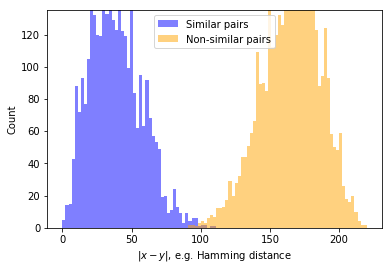

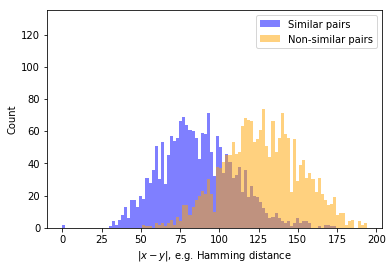

3859/3859 [==============================] - 2s 408us/step
2018-03-09 23:43:52,102 - root - DEBUG - [Iteration = 89] Training Loss = 18.22838914125882, Testing Loss = 35.68781733902108
2018-03-09 23:43:52,104 - root - DEBUG - Iteration 89 (current beta = 4700261881895380.0)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2697
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2652
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2784
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2876
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2623
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2702
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2842
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2606
Epoch 9/20
7237/7237 [=======================

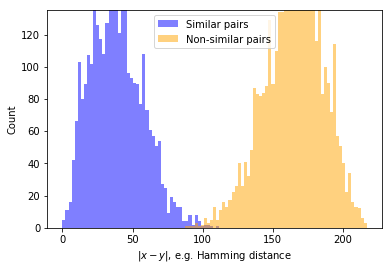

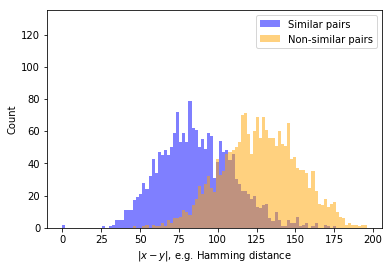

3859/3859 [==============================] - 2s 407us/step
2018-03-09 23:47:27,234 - root - DEBUG - [Iteration = 90] Training Loss = 18.23554740236068, Testing Loss = 35.635514941664056
2018-03-09 23:47:27,235 - root - DEBUG - Iteration 90 (current beta = 7050392822843070.0)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2459
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2513
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2486
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2381
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2632
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2557
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2461
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2578
Epoch 9/20
7237/7237 [======================

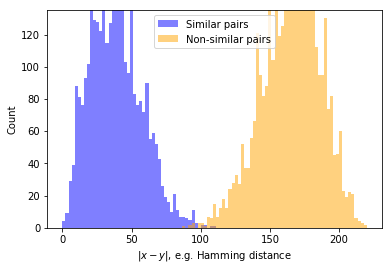

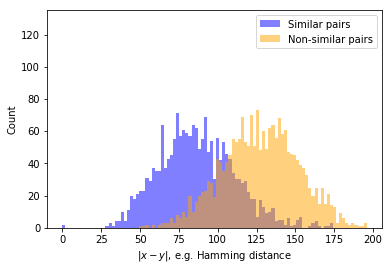

3859/3859 [==============================] - 2s 414us/step
2018-03-09 23:51:02,827 - root - DEBUG - [Iteration = 91] Training Loss = 18.206882628350854, Testing Loss = 35.688501177627394
2018-03-09 23:51:02,828 - root - DEBUG - Iteration 91 (current beta = 1.0575589234264604e+16)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2483
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2288
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2384
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2361
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2397
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2352
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2377
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2182
Epoch 9/20
7237/7237 [=================

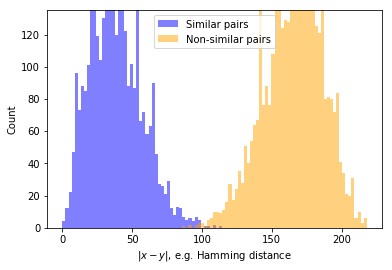

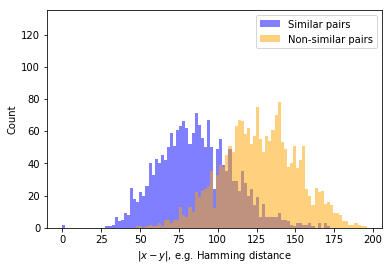

3859/3859 [==============================] - 2s 412us/step
2018-03-09 23:54:39,745 - root - DEBUG - [Iteration = 92] Training Loss = 18.178391400598535, Testing Loss = 35.71193644851562
2018-03-09 23:54:39,746 - root - DEBUG - Iteration 92 (current beta = 1.5863383851396906e+16)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2063
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2234
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2236
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2193
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2120
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2144
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2024
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2081
Epoch 9/20
7237/7237 [==================

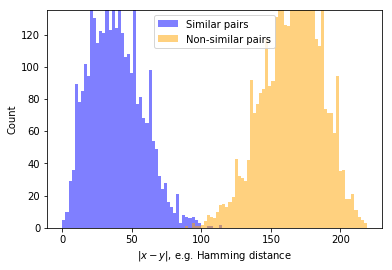

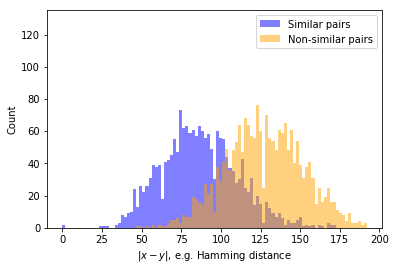

3859/3859 [==============================] - 2s 414us/step
2018-03-09 23:58:16,751 - root - DEBUG - [Iteration = 93] Training Loss = 18.15998101975685, Testing Loss = 35.70420924490924
2018-03-09 23:58:16,752 - root - DEBUG - Iteration 93 (current beta = 2.379507577709536e+16)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.1988
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.1872
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2005
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.1948
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.2090
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.1978
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.1886
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.1835
Epoch 9/20
7237/7237 [====================

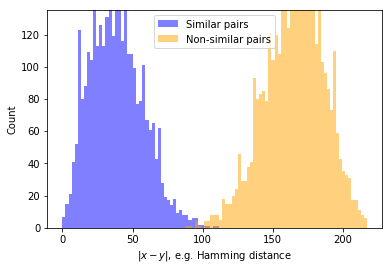

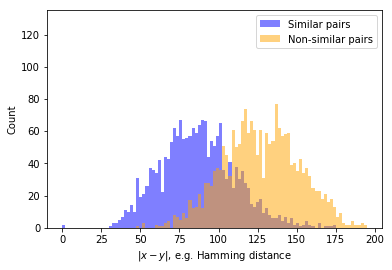

3859/3859 [==============================] - 2s 414us/step
2018-03-10 00:01:53,633 - root - DEBUG - [Iteration = 94] Training Loss = 18.16612728070007, Testing Loss = 35.71748261106975
2018-03-10 00:01:53,634 - root - DEBUG - Iteration 94 (current beta = 3.569261366564304e+16)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.1912
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.1657
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.1811
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.1747
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.1591
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.1786
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.1867
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.1760
Epoch 9/20
7237/7237 [====================

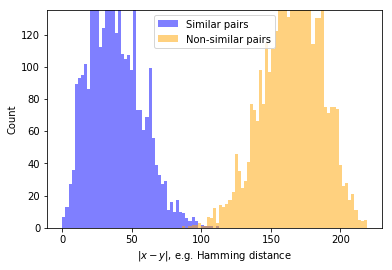

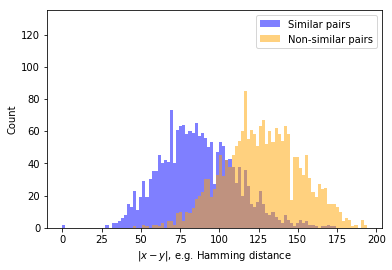

3859/3859 [==============================] - 2s 438us/step
2018-03-10 00:05:30,806 - root - DEBUG - [Iteration = 95] Training Loss = 18.105595734430082, Testing Loss = 35.73281567453195
2018-03-10 00:05:30,807 - root - DEBUG - Iteration 95 (current beta = 5.353892049846456e+16)
Epoch 1/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.1505
Epoch 2/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.1530
Epoch 3/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.1368
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.1551
Epoch 5/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.1665
Epoch 6/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.1491
Epoch 7/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.1462
Epoch 8/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.1538
Epoch 9/20
7237/7237 [===================

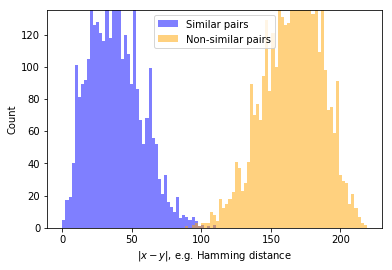

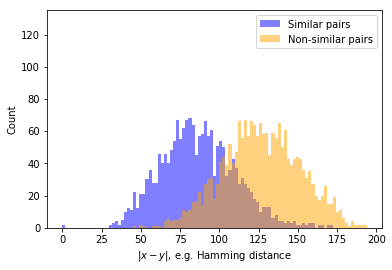

3859/3859 [==============================] - 2s 416us/step
2018-03-10 00:09:12,367 - root - DEBUG - [Iteration = 96] Training Loss = 18.12008012331074, Testing Loss = 35.83533091519156
2018-03-10 00:09:12,368 - root - DEBUG - Iteration 96 (current beta = 8.030838074769683e+16)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.1543
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.1229
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.1300
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.1323
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.1271
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.1238
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.1224
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.1373
Epoch 9/20
7237/7237 [====================

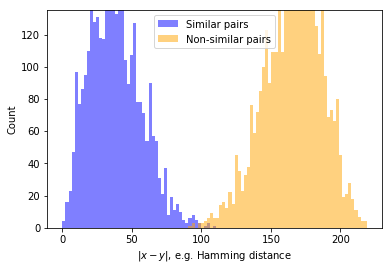

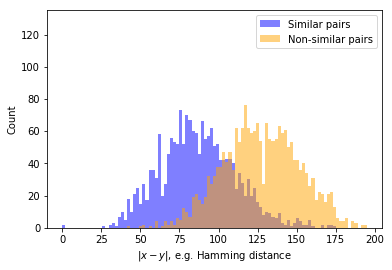

3859/3859 [==============================] - 2s 415us/step
2018-03-10 00:12:49,108 - root - DEBUG - [Iteration = 97] Training Loss = 18.096632978938242, Testing Loss = 35.78104214249389
2018-03-10 00:12:49,109 - root - DEBUG - Iteration 97 (current beta = 1.2046257112154525e+17)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.1304
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.1298
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.0927
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.1074
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.1218
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.0974
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.1080
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.1028
Epoch 9/20
7237/7237 [==================

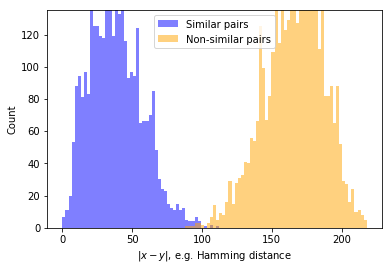

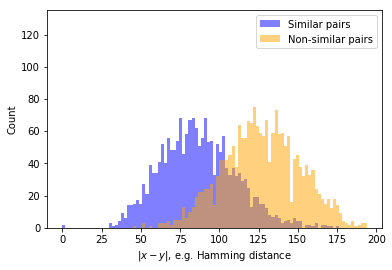

3859/3859 [==============================] - 2s 440us/step
2018-03-10 00:16:26,391 - root - DEBUG - [Iteration = 98] Training Loss = 18.074118570940787, Testing Loss = 35.75410737173333
2018-03-10 00:16:26,392 - root - DEBUG - Iteration 98 (current beta = 1.806938566823179e+17)
Epoch 1/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.0929
Epoch 2/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.1047
Epoch 3/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.1088
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.0923
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.0974
Epoch 6/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.0937
Epoch 7/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.0862
Epoch 8/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.1035
Epoch 9/20
7237/7237 [===================

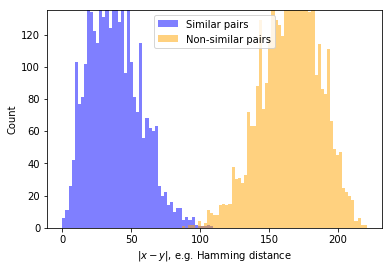

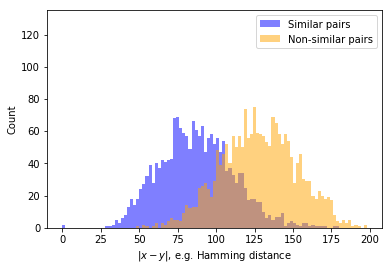

3859/3859 [==============================] - 2s 415us/step
2018-03-10 00:20:07,663 - root - DEBUG - [Iteration = 99] Training Loss = 18.068010324962035, Testing Loss = 35.7014330512781
2018-03-10 00:20:07,664 - root - DEBUG - Iteration 99 (current beta = 2.7104078502347683e+17)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.0850
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.0811
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.0830
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.0669
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.0814
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.0758
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.0949
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.0644
Epoch 9/20
7237/7237 [===================

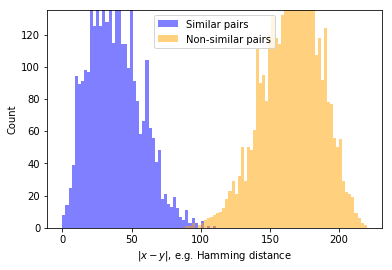

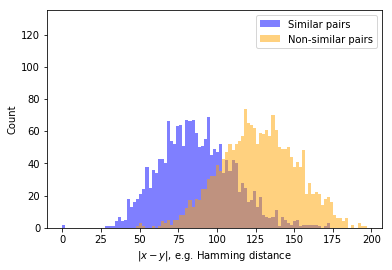

3859/3859 [==============================] - 2s 434us/step
2018-03-10 00:23:44,753 - root - DEBUG - [Iteration = 100] Training Loss = 18.029797257911902, Testing Loss = 35.731404702136416
2018-03-10 00:23:44,754 - root - DEBUG - Iteration 100 (current beta = 4.065611775352152e+17)
Epoch 1/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.0520
Epoch 2/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.0581
Epoch 3/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.0533
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.0693
Epoch 5/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.0673
Epoch 6/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.0631
Epoch 7/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.0630
Epoch 8/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.0502
Epoch 9/20
7237/7237 [================

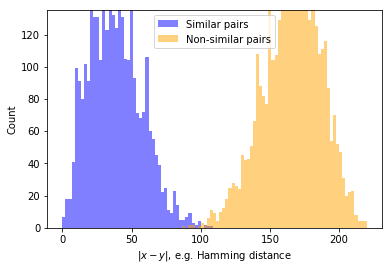

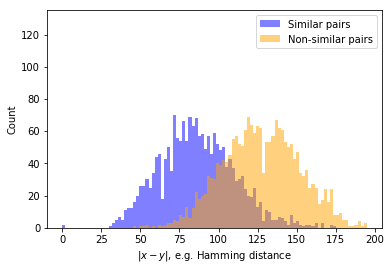

3859/3859 [==============================] - 2s 412us/step
2018-03-10 00:27:26,168 - root - DEBUG - [Iteration = 101] Training Loss = 18.022553344614288, Testing Loss = 35.70359894030142
2018-03-10 00:27:26,169 - root - DEBUG - Iteration 101 (current beta = 6.098417663028229e+17)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.0630
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.0575
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.0559
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.0476
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.0420
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.0334
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.0564
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.0628
Epoch 9/20
7237/7237 [=================

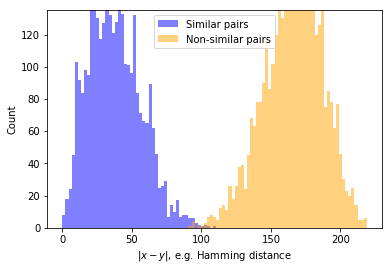

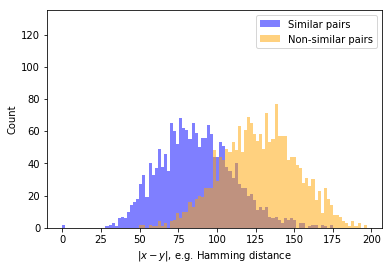

3859/3859 [==============================] - 2s 415us/step
2018-03-10 00:31:02,348 - root - DEBUG - [Iteration = 102] Training Loss = 17.968841152822378, Testing Loss = 35.67516609620912
2018-03-10 00:31:02,349 - root - DEBUG - Iteration 102 (current beta = 9.147626494542344e+17)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.0346
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.0325
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.0421
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.0351
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.0320
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.0292
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.0268
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.0429
Epoch 9/20
7237/7237 [=================

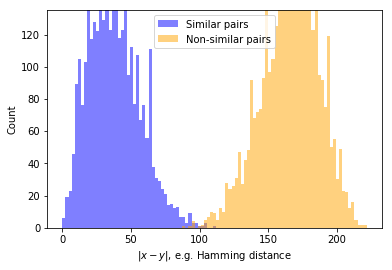

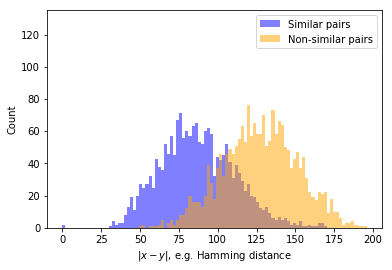

3859/3859 [==============================] - 2s 439us/step
2018-03-10 00:34:39,407 - root - DEBUG - [Iteration = 103] Training Loss = 17.978287444286654, Testing Loss = 35.75791086412891
2018-03-10 00:34:39,408 - root - DEBUG - Iteration 103 (current beta = 1.3721439741813514e+18)
Epoch 1/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.0096
Epoch 2/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.0103
Epoch 3/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.0017
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.0132
Epoch 5/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.0054
Epoch 6/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.0030
Epoch 7/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.0161
Epoch 8/20
7237/7237 [==============================] - 11s 1ms/step - loss: 18.0102
Epoch 9/20
7237/7237 [================

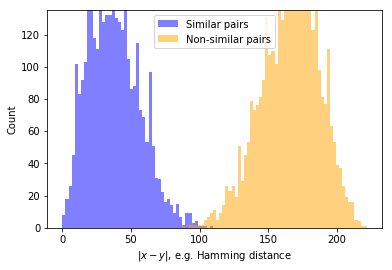

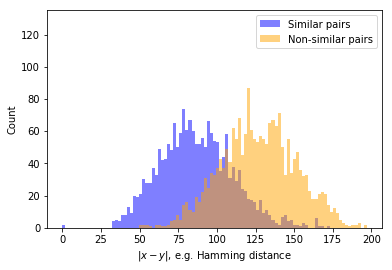

3859/3859 [==============================] - 2s 412us/step
2018-03-10 00:38:20,542 - root - DEBUG - [Iteration = 104] Training Loss = 17.945496785932274, Testing Loss = 35.75741864708799
2018-03-10 00:38:20,543 - root - DEBUG - Iteration 104 (current beta = 2.0582159612720271e+18)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 17.9951
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 17.9912
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 17.9934
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 17.9987
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 17.9891
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 18.0115
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 17.9939
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 17.9846
Epoch 9/20
7237/7237 [================

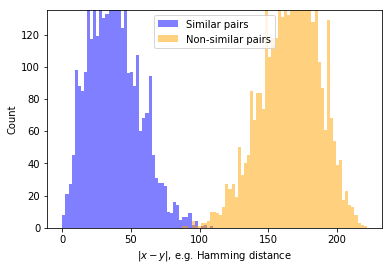

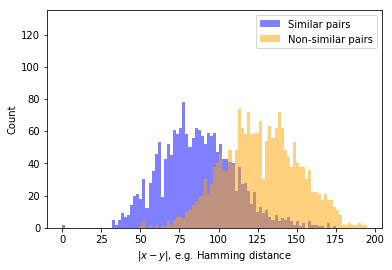

3859/3859 [==============================] - 2s 438us/step
2018-03-10 00:41:57,376 - root - DEBUG - [Iteration = 105] Training Loss = 17.93241648363016, Testing Loss = 35.760023723522224
2018-03-10 00:41:57,377 - root - DEBUG - Iteration 105 (current beta = 3.0873239419080407e+18)
Epoch 1/20
7237/7237 [==============================] - 11s 1ms/step - loss: 17.9845
Epoch 2/20
7237/7237 [==============================] - 11s 1ms/step - loss: 17.9778
Epoch 3/20
7237/7237 [==============================] - 11s 1ms/step - loss: 17.9724
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 17.9900
Epoch 5/20
7237/7237 [==============================] - 11s 1ms/step - loss: 17.9765
Epoch 6/20
7237/7237 [==============================] - 11s 1ms/step - loss: 17.9719
Epoch 7/20
7237/7237 [==============================] - 11s 1ms/step - loss: 17.9707
Epoch 8/20
7237/7237 [==============================] - 11s 1ms/step - loss: 17.9639
Epoch 9/20
7237/7237 [================

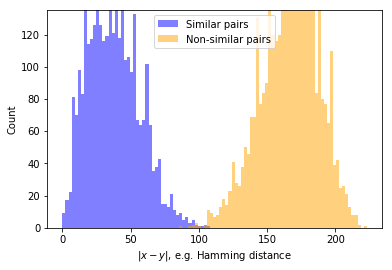

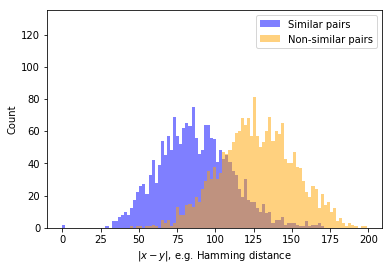

3859/3859 [==============================] - 2s 417us/step
2018-03-10 00:45:39,007 - root - DEBUG - [Iteration = 106] Training Loss = 17.89683095378014, Testing Loss = 35.80442497241556
2018-03-10 00:45:39,008 - root - DEBUG - Iteration 106 (current beta = 4.630985912862061e+18)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 17.9699
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 17.9789
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 17.9556
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 17.9603
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 17.9422
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 17.9614
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 17.9512
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 17.9748
Epoch 9/20
7237/7237 [==================

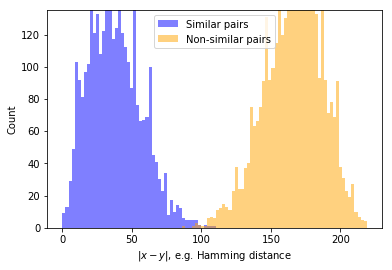

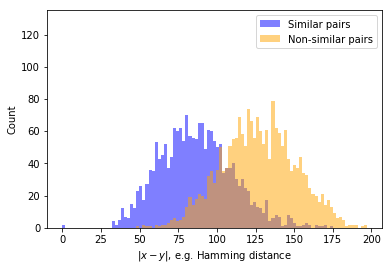

3859/3859 [==============================] - 2s 410us/step
2018-03-10 00:49:15,718 - root - DEBUG - [Iteration = 107] Training Loss = 17.905184038538323, Testing Loss = 35.72155482956213
2018-03-10 00:49:15,719 - root - DEBUG - Iteration 107 (current beta = 6.946478869293091e+18)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 17.9412
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 17.9649
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 17.9594
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 17.9414
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 17.9468
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 17.9357
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 17.9339
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 17.9278
Epoch 9/20
7237/7237 [=================

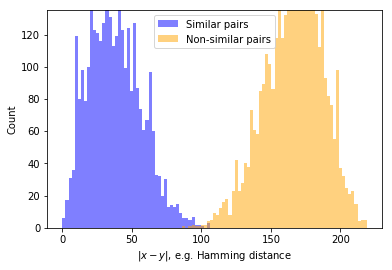

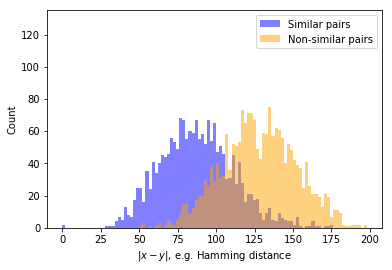

3859/3859 [==============================] - 2s 437us/step
2018-03-10 00:52:52,781 - root - DEBUG - [Iteration = 108] Training Loss = 17.889899628422974, Testing Loss = 35.756686892958
2018-03-10 00:52:52,782 - root - DEBUG - Iteration 108 (current beta = 1.0419718303939637e+19)
Epoch 1/20
7237/7237 [==============================] - 11s 1ms/step - loss: 17.9338
Epoch 2/20
7237/7237 [==============================] - 11s 1ms/step - loss: 17.9121
Epoch 3/20
7237/7237 [==============================] - 11s 1ms/step - loss: 17.9360
Epoch 4/20
7237/7237 [==============================] - 11s 1ms/step - loss: 17.9285
Epoch 5/20
7237/7237 [==============================] - 11s 1ms/step - loss: 17.9328
Epoch 6/20
7237/7237 [==============================] - 11s 1ms/step - loss: 17.9282
Epoch 7/20
7237/7237 [==============================] - 11s 1ms/step - loss: 17.9271
Epoch 8/20
7237/7237 [==============================] - 11s 1ms/step - loss: 17.9259
Epoch 9/20
7237/7237 [==================

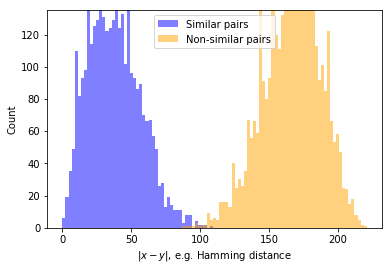

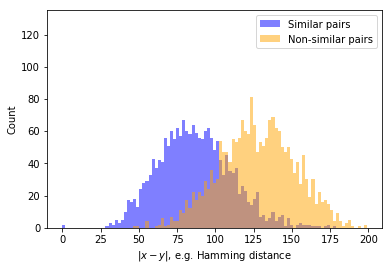

3859/3859 [==============================] - 2s 416us/step
2018-03-10 00:56:34,056 - root - DEBUG - [Iteration = 109] Training Loss = 17.852651240072216, Testing Loss = 35.68243910173395
2018-03-10 00:56:34,057 - root - DEBUG - Iteration 109 (current beta = 1.5629577455909456e+19)
Epoch 1/20
7237/7237 [==============================] - 10s 1ms/step - loss: 17.9234
Epoch 2/20
7237/7237 [==============================] - 10s 1ms/step - loss: 17.9061
Epoch 3/20
7237/7237 [==============================] - 10s 1ms/step - loss: 17.9219
Epoch 4/20
7237/7237 [==============================] - 10s 1ms/step - loss: 17.8890
Epoch 5/20
7237/7237 [==============================] - 10s 1ms/step - loss: 17.9063
Epoch 6/20
7237/7237 [==============================] - 10s 1ms/step - loss: 17.9049
Epoch 7/20
7237/7237 [==============================] - 10s 1ms/step - loss: 17.9030
Epoch 8/20
7237/7237 [==============================] - 10s 1ms/step - loss: 17.9058
Epoch 9/20
7237/7237 [================

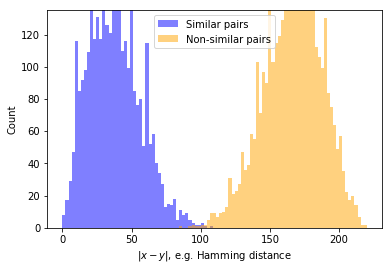

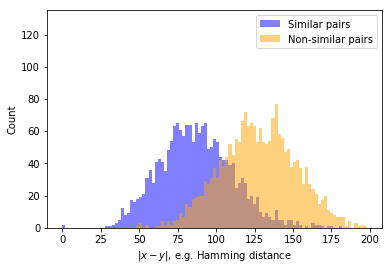

3859/3859 [==============================] - 2s 439us/step
2018-03-10 01:00:11,247 - root - DEBUG - [Iteration = 110] Training Loss = 17.852332461913086, Testing Loss = 35.79167578757257


In [185]:
for i in range(100):
    logger.debug("Iteration {:} (current beta = {:})".format(m, beta))
    m += 1

    # Train a model with 4 inputs and 1 dummy output.
    model.fit({'image_1': X1, 'image_2': X2, 'similarity': S, 'weight': W}, [S], verbose=verbose, epochs=number_of_epochs)
    beta *= beta_factor

    representation_model = Model(image_a, encoded_a)
    visualize(X1, X2, groundTruth, representation_model)
    visualize(X1_val, X2_val, groundTruth_val, representation_model)

    train_loss = model.evaluate({'image_1': X1, 'image_2': X2, 'similarity': S, 'weight': W}, [S])
    test_loss  = model.evaluate({'image_1': X1_val, 'image_2': X2_val, 'similarity': S_val, 'weight': W_val}, [S_val])
    logger.debug("[Iteration = {:}] Training Loss = {:}, Testing Loss = {:}".format(m, train_loss, test_loss))
    train_losses.append(train_loss)
    test_losses.append(test_loss)

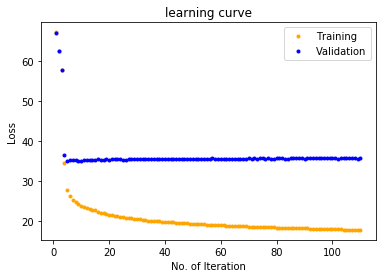

In [186]:
plt.figure()
plt.title("learning curve")
plt.plot(range(1,len(train_losses)+1), train_losses, '.', color='orange', label='Training')
plt.plot(range(1,len(test_losses)+1), test_losses, '.', color='blue', label='Validation')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("No. of Iteration")
plt.show()

## Save Model

In [187]:
MODEL_NAME = str(datetime.date.today()) + EXPERIMENT_NAME + "[Iteration={:}]".format(m)
logger.debug("Save model to {:}.h5".format(MODEL_NAME))
model.save(MODEL_NAME + ".h5")

2018-03-10 01:00:11,366 - root - DEBUG - Save model to 2018-03-10[HashNet][Iteration=110].h5


## Visualize Performance 

__Obtain a representation model__

This representation model is the same as the trained model above without the loss layer at the very end.

In [171]:
representation_model = Model(image_a, encoded_a)

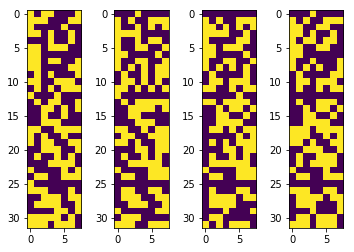

In [173]:
# Get sample output
# Reshaped to be (32,-1) for visualization purposes.
pred_X1 = representation_model.predict(X1)
plt.subplot(1,4,1)
plt.imshow(pred_X1[:1].reshape(32,-1) > 0)
plt.subplot(1,4,2)
plt.imshow(pred_X1[1:2].reshape(32,-1) > 0)
plt.subplot(1,4,3)
plt.imshow(pred_X1[2:3].reshape(32,-1) > 0)
plt.subplot(1,4,4)
plt.imshow(pred_X1[3:4].reshape(32,-1) > 0)
plt.show()

## Evaluate Performance
Calculate the hamming distance input pairs and plot the corresponding histogram.

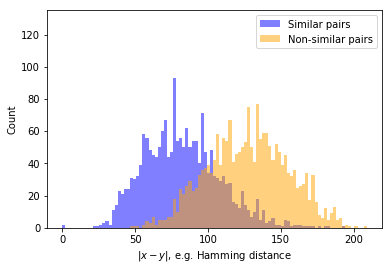

In [176]:
representation_model = Model(image_a, encoded_a)
visualize(X1_val, X2_val, groundTruth_val, representation_model)

## Appendix: Architecture Details

In [175]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_1 (InputLayer)            (None, 1, 76, 121)   0                                            
__________________________________________________________________________________________________
image_2 (InputLayer)            (None, 1, 76, 121)   0                                            
__________________________________________________________________________________________________
model_43 (Model)                (None, 256, 6, 11)   1089728     image_1[0][0]                    
                                                                 image_2[0][0]                    
__________________________________________________________________________________________________
flatten_9 (Flatten)             (None, 16896)        0           model_43[1][0]                   
__________

In [174]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 1, 76, 121)        0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 64, 70, 115)       3200      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64, 70, 115)       0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 64, 35, 57)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 192, 33, 55)       110784    
_________________________________________________________________
dropout_5 (Dropout)          (None, 192, 33, 55)       0         
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 192, 16, 27)       0         
__________

## MRR

In [184]:
import songdb

In [ ]:
logger.debug("Querying database")
refs, queries, groundTruth = songdb.get